In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import scipy
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import keras
from keras.optimizers import Adadelta
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation
from keras.initializers import glorot_uniform
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
from sklearn.metrics import confusion_matrix
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML, display, clear_output, SVG
import ipywidgets as widgets
#%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.makedirs('models')

Using TensorFlow backend.
/home/mshaikh2/.conda/envs/tf-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data Processing

In [2]:
classes = os.listdir('by_class')

data_pairs = []
for class_int, class_dir in enumerate(classes):
    image_path = 'by_class/{}/train_{}/'.format(class_dir, class_dir)
    image_files = os.listdir(image_path)
    for d in [image_path + img for img in image_files]:
        data_pairs.append((d, class_int))
        
x_data = np.array(data_pairs)[::,0]
y_data = keras.utils.to_categorical(np.array(data_pairs)[::,1], len(classes))

In [3]:
full_idx = np.arange(0, len(x_data))
train_idx = np.random.choice(full_idx, 
                             int(len(x_data)*0.8), 
                             replace=False)
test_idx = np.setdiff1d(full_idx, train_idx)

x_train = x_data[train_idx]
y_train = y_data[train_idx]
x_test = x_data[test_idx]
y_test = y_data[test_idx]
print(len(x_data))
print(y_train.shape)
print(x_train.shape)

731668
(585334, 62)
(585334,)


52


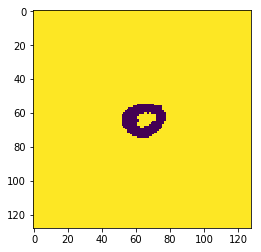

In [4]:
try:
    im = imageio.imread(data_pairs[591000][0], pilmode='L')/255
except TypeError as e:
    im = scipy.misc.imread(data_pairs[591000][0], mode='L')/255
print(data_pairs[590000][1])
plt.imshow(im)

In [5]:
def batch_generator(x, y, batch_size=32):
    while True:
        idx = np.random.randint(0, len(x), batch_size)
        im_files = x[idx]
        ims = []
        labels = y[idx]
        
        for i in im_files:
            try:
                image = imageio.imread(i, pilmode='L')/255
            except TypeError as e:
                image = scipy.misc.imread(i, mode='L')/255
            image = np.expand_dims(image, axis=0)
            ims.append(image)

        yield np.array(ims), labels

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
12


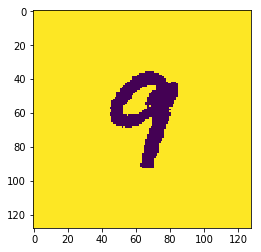

In [6]:
# quick test
for gen, label in batch_generator(x_train, y_train):
    for im, l in zip(gen, label):
        print(l)
        print(np.argmax(l))
        plt.imshow(im.reshape(128,128))
        plt.show()
        break
    break

# Model

conv1.shape (?, 64, 64, 64)
conv2.shape (?, 64, 64, 64)
x.shape (?, 64, 64, 64)
---------block 1 end-----------
conv1.shape (?, 128, 32, 32)
conv2.shape (?, 128, 32, 32)
x.shape (?, 128, 32, 32)
---------block 2 end-----------
conv1.shape (?, 256, 16, 16)
conv2.shape (?, 256, 16, 16)
x.shape (?, 256, 16, 16)
---------block 3 end-----------
conv1.shape (?, 512, 8, 8)
conv2.shape (?, 512, 8, 8)
x.shape (?, 512, 8, 8)
---------block 4 end-----------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 128, 128)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1, 128, 128)  512         input_1[0][0]                    
______________________________________________________

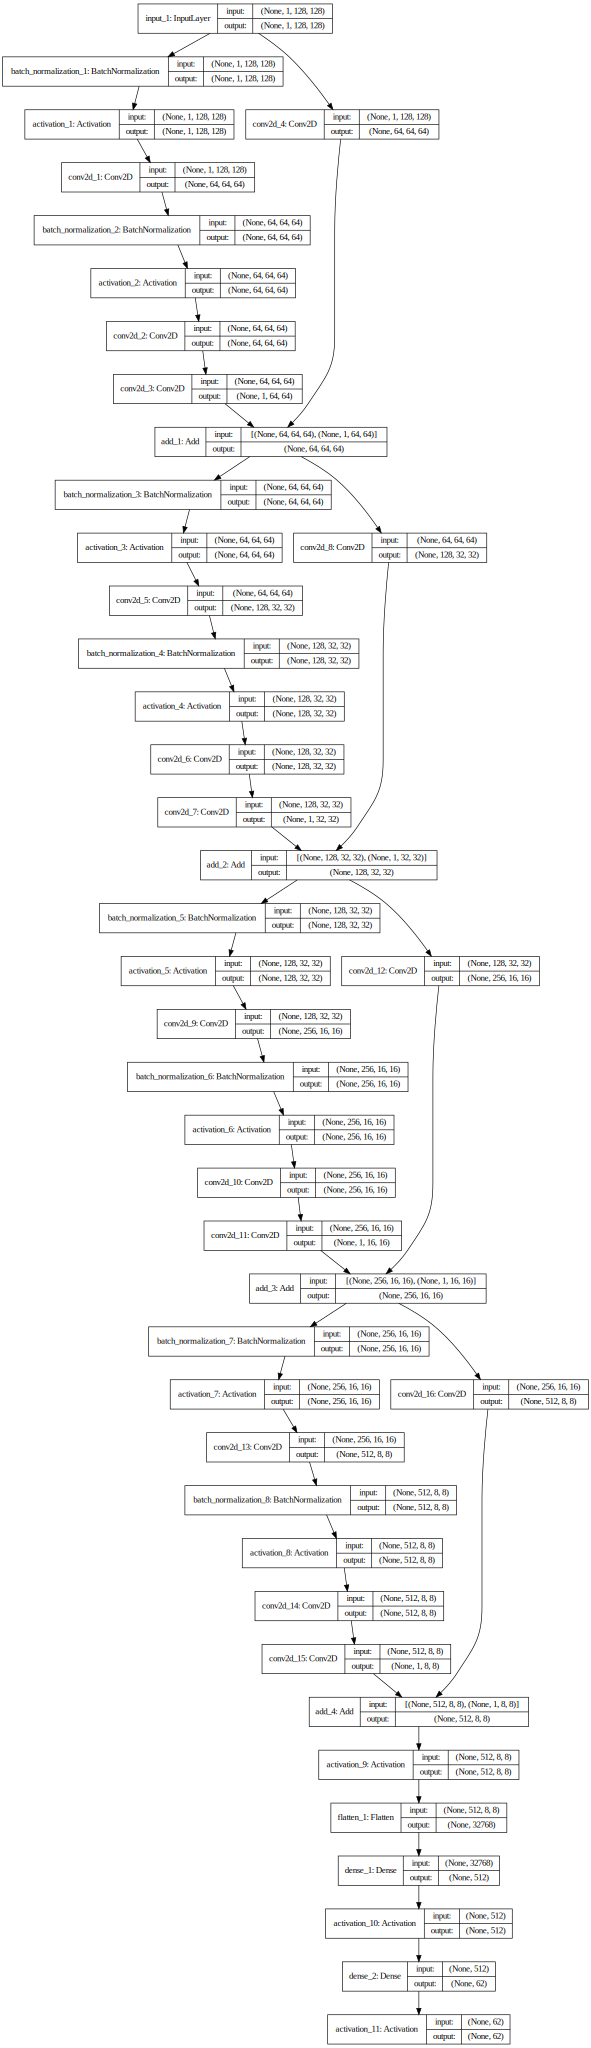

In [7]:
img_rows, img_cols = 128, 128
input_shape = (1, img_rows, img_cols)

input1 = Input(shape=(1, 128, 128))

       
# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    print('conv2.shape', conv2.shape)
    residual = Conv2D(1, (1, 1), strides=(1, 1), data_format='channels_first')(conv2)
    
    
    x = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)
    print('x.shape', x.shape)
    out = Add()([x, residual])
    
    return out

# Combining resuidal blocks into a network
res1 = res_block(input1, 64)
print('---------block 1 end-----------')
res2 = res_block(res1, 128)
print('---------block 2 end-----------')
res3 = res_block(res2, 256)
print('---------block 3 end-----------')
res4 = res_block(res3, 512)
print('---------block 4 end-----------')

# Classifier block
act1 = Activation('relu')(res4)
flatten1 = Flatten()(act1)
dense1 = Dense(512)(flatten1)
act2 = Activation('relu')(dense1)
dense2 = Dense(62)(act2)
output1 = Activation('softmax')(dense2)

model = Model(inputs=input1, outputs=output1)

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(lr=0.01),
              metrics=['categorical_accuracy'])

model.summary()

plot_model(model, to_file='model.png')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

# Training

In [8]:
callback_list = []
train_name = str(int(time.time()))
initial_epoch = 0
if not os.path.exists('model_res/' + train_name):
    os.makedirs('model_res/' + train_name)
model_path="model_res/" + train_name +"/model.hdf5"

callback_list.append(EarlyStopping(monitor='val_loss', patience=1000))
callback_list.append(TensorBoard(log_dir='./logs/res/' + train_name))
callback_list.append(ModelCheckpoint(model_path, period=10, monitor='val_loss', mode='min'))
# model.load_weights('models_res/1537292473/model_160-0.86-0.561555.hdf5')
train_gen = batch_generator(x_train, y_train, batch_size=256)
val_gen = batch_generator(x_test[:int(0.5 * x_test.shape[0])], y_test[:int(0.5 * y_test.shape[0]),:], batch_size=256)

hist = model.fit_generator(generator=train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=1,
                    validation_steps=1,
                    epochs=100000,
                    initial_epoch=initial_epoch,
                    verbose=1,
                    callbacks=callback_list)

Epoch 1/100000
1/1 [==============================] - 3s 3s/step - loss: 5.4420 - categorical_accuracy: 0.0156 - val_loss: 4.1963 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100000
1/1 [==============================] - 1s 647ms/step - loss: 4.7670 - categorical_accuracy: 0.0234 - val_loss: 4.1577 - val_categorical_accuracy: 0.0117
Epoch 3/100000
1/1 [==============================] - 1s 635ms/step - loss: 4.5454 - categorical_accuracy: 0.0234 - val_loss: 4.1414 - val_categorical_accuracy: 0.0117
Epoch 4/100000
1/1 [==============================] - 1s 638ms/step - loss: 4.2902 - categorical_accuracy: 0.0391 - val_loss: 4.1530 - val_categorical_accuracy: 0.0039
Epoch 5/100000
1/1 [==============================] - 1s 635ms/step - loss: 4.2350 - categorical_accuracy: 0.0508 - val_loss: 4.1481 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100000
1/1 [==============================] - 1s 629ms/step - loss: 4.2099 - categorical_accuracy: 0.0352 - val_loss: 4.1502 - val_categorical_accu

1/1 [==============================] - 1s 640ms/step - loss: 3.2938 - categorical_accuracy: 0.2109 - val_loss: 4.0010 - val_categorical_accuracy: 0.0312
Epoch 50/100000
1/1 [==============================] - 1s 1s/step - loss: 3.1743 - categorical_accuracy: 0.2422 - val_loss: 3.9772 - val_categorical_accuracy: 0.1172
Epoch 51/100000
1/1 [==============================] - 1s 660ms/step - loss: 3.3036 - categorical_accuracy: 0.2031 - val_loss: 4.0484 - val_categorical_accuracy: 0.0000e+00
Epoch 52/100000
1/1 [==============================] - 1s 642ms/step - loss: 3.2823 - categorical_accuracy: 0.1836 - val_loss: 4.0010 - val_categorical_accuracy: 0.0156
Epoch 53/100000
1/1 [==============================] - 1s 807ms/step - loss: 3.1251 - categorical_accuracy: 0.2266 - val_loss: 4.0171 - val_categorical_accuracy: 0.0039
Epoch 54/100000
1/1 [==============================] - 1s 661ms/step - loss: 3.4198 - categorical_accuracy: 0.1797 - val_loss: 4.0125 - val_categorical_accuracy: 0.0000e+

Epoch 98/100000
1/1 [==============================] - 1s 653ms/step - loss: 2.5927 - categorical_accuracy: 0.3594 - val_loss: 4.0362 - val_categorical_accuracy: 0.0312
Epoch 99/100000
1/1 [==============================] - 1s 816ms/step - loss: 2.9172 - categorical_accuracy: 0.3086 - val_loss: 3.9644 - val_categorical_accuracy: 0.0312
Epoch 100/100000
1/1 [==============================] - 1s 1s/step - loss: 2.6139 - categorical_accuracy: 0.3867 - val_loss: 4.0184 - val_categorical_accuracy: 0.0391
Epoch 101/100000
1/1 [==============================] - 1s 793ms/step - loss: 2.6334 - categorical_accuracy: 0.3789 - val_loss: 4.0810 - val_categorical_accuracy: 0.0156
Epoch 102/100000
1/1 [==============================] - 1s 802ms/step - loss: 2.7946 - categorical_accuracy: 0.3477 - val_loss: 4.0219 - val_categorical_accuracy: 0.0273
Epoch 103/100000
1/1 [==============================] - 1s 813ms/step - loss: 2.5478 - categorical_accuracy: 0.3906 - val_loss: 4.0350 - val_categorical_ac

Epoch 147/100000
1/1 [==============================] - 1s 797ms/step - loss: 2.3734 - categorical_accuracy: 0.4102 - val_loss: 4.3398 - val_categorical_accuracy: 0.0352
Epoch 148/100000
1/1 [==============================] - 1s 801ms/step - loss: 2.1553 - categorical_accuracy: 0.4531 - val_loss: 4.3514 - val_categorical_accuracy: 0.0430
Epoch 149/100000
1/1 [==============================] - 1s 794ms/step - loss: 2.2433 - categorical_accuracy: 0.4414 - val_loss: 4.4779 - val_categorical_accuracy: 0.0352
Epoch 150/100000
1/1 [==============================] - 1s 1s/step - loss: 2.1292 - categorical_accuracy: 0.4258 - val_loss: 4.3076 - val_categorical_accuracy: 0.0195
Epoch 151/100000
1/1 [==============================] - 1s 800ms/step - loss: 2.0019 - categorical_accuracy: 0.4805 - val_loss: 4.3813 - val_categorical_accuracy: 0.0312
Epoch 152/100000
1/1 [==============================] - 1s 801ms/step - loss: 1.9677 - categorical_accuracy: 0.5039 - val_loss: 4.3596 - val_categorical_

Epoch 196/100000
1/1 [==============================] - 1s 666ms/step - loss: 1.7573 - categorical_accuracy: 0.5508 - val_loss: 5.3042 - val_categorical_accuracy: 0.0117
Epoch 197/100000
1/1 [==============================] - 1s 811ms/step - loss: 1.9924 - categorical_accuracy: 0.4961 - val_loss: 5.2849 - val_categorical_accuracy: 0.0273
Epoch 198/100000
1/1 [==============================] - 1s 792ms/step - loss: 1.6779 - categorical_accuracy: 0.5625 - val_loss: 5.1047 - val_categorical_accuracy: 0.0469
Epoch 199/100000
1/1 [==============================] - 1s 801ms/step - loss: 1.7693 - categorical_accuracy: 0.5625 - val_loss: 5.2324 - val_categorical_accuracy: 0.0586
Epoch 200/100000
1/1 [==============================] - 1s 1s/step - loss: 1.8404 - categorical_accuracy: 0.4805 - val_loss: 5.3395 - val_categorical_accuracy: 0.0625
Epoch 201/100000
1/1 [==============================] - 1s 677ms/step - loss: 1.9294 - categorical_accuracy: 0.5352 - val_loss: 5.3994 - val_categorical_

Epoch 245/100000
1/1 [==============================] - 1s 652ms/step - loss: 1.7258 - categorical_accuracy: 0.5586 - val_loss: 6.8814 - val_categorical_accuracy: 0.0664
Epoch 246/100000
1/1 [==============================] - 1s 665ms/step - loss: 1.7333 - categorical_accuracy: 0.5547 - val_loss: 6.2637 - val_categorical_accuracy: 0.0625
Epoch 247/100000
1/1 [==============================] - 1s 652ms/step - loss: 1.5463 - categorical_accuracy: 0.5938 - val_loss: 7.2049 - val_categorical_accuracy: 0.0000e+00
Epoch 248/100000
1/1 [==============================] - 1s 640ms/step - loss: 1.5660 - categorical_accuracy: 0.6367 - val_loss: 6.3141 - val_categorical_accuracy: 0.0625
Epoch 249/100000
1/1 [==============================] - 1s 791ms/step - loss: 1.9422 - categorical_accuracy: 0.5117 - val_loss: 6.2361 - val_categorical_accuracy: 0.0781
Epoch 250/100000
1/1 [==============================] - 1s 1s/step - loss: 1.8313 - categorical_accuracy: 0.5195 - val_loss: 6.7003 - val_categori

Epoch 294/100000
1/1 [==============================] - 1s 651ms/step - loss: 1.5187 - categorical_accuracy: 0.5977 - val_loss: 8.0998 - val_categorical_accuracy: 0.0391
Epoch 295/100000
1/1 [==============================] - 1s 809ms/step - loss: 1.2197 - categorical_accuracy: 0.6797 - val_loss: 8.8378 - val_categorical_accuracy: 0.0117
Epoch 296/100000
1/1 [==============================] - 1s 798ms/step - loss: 1.4478 - categorical_accuracy: 0.5898 - val_loss: 8.7134 - val_categorical_accuracy: 0.0117
Epoch 297/100000
1/1 [==============================] - 1s 803ms/step - loss: 1.5483 - categorical_accuracy: 0.6094 - val_loss: 8.5173 - val_categorical_accuracy: 0.0156
Epoch 298/100000
1/1 [==============================] - 1s 798ms/step - loss: 1.6260 - categorical_accuracy: 0.5977 - val_loss: 7.7194 - val_categorical_accuracy: 0.0312
Epoch 299/100000
1/1 [==============================] - 1s 782ms/step - loss: 1.3745 - categorical_accuracy: 0.6641 - val_loss: 8.7960 - val_categoric

Epoch 343/100000
1/1 [==============================] - 1s 671ms/step - loss: 1.3989 - categorical_accuracy: 0.6172 - val_loss: 8.5214 - val_categorical_accuracy: 0.0508
Epoch 344/100000
1/1 [==============================] - 1s 801ms/step - loss: 1.4582 - categorical_accuracy: 0.5938 - val_loss: 8.5284 - val_categorical_accuracy: 0.0586
Epoch 345/100000
1/1 [==============================] - 1s 789ms/step - loss: 1.5251 - categorical_accuracy: 0.6367 - val_loss: 8.6182 - val_categorical_accuracy: 0.0273
Epoch 346/100000
1/1 [==============================] - 1s 787ms/step - loss: 1.4841 - categorical_accuracy: 0.6055 - val_loss: 8.9483 - val_categorical_accuracy: 0.1055
Epoch 347/100000
1/1 [==============================] - 1s 788ms/step - loss: 1.3874 - categorical_accuracy: 0.5938 - val_loss: 8.9458 - val_categorical_accuracy: 0.0547
Epoch 348/100000
1/1 [==============================] - 1s 766ms/step - loss: 1.2089 - categorical_accuracy: 0.6914 - val_loss: 8.7538 - val_categoric

Epoch 392/100000
1/1 [==============================] - 1s 684ms/step - loss: 1.3802 - categorical_accuracy: 0.6250 - val_loss: 7.9970 - val_categorical_accuracy: 0.0586
Epoch 393/100000
1/1 [==============================] - 1s 649ms/step - loss: 1.2297 - categorical_accuracy: 0.6523 - val_loss: 8.4308 - val_categorical_accuracy: 0.0664
Epoch 394/100000
1/1 [==============================] - 1s 812ms/step - loss: 1.3432 - categorical_accuracy: 0.6133 - val_loss: 8.4801 - val_categorical_accuracy: 0.0352
Epoch 395/100000
1/1 [==============================] - 1s 650ms/step - loss: 1.3309 - categorical_accuracy: 0.6445 - val_loss: 7.9488 - val_categorical_accuracy: 0.0586
Epoch 396/100000
1/1 [==============================] - 1s 824ms/step - loss: 1.1848 - categorical_accuracy: 0.6523 - val_loss: 7.8966 - val_categorical_accuracy: 0.0703
Epoch 397/100000
1/1 [==============================] - 1s 802ms/step - loss: 1.3082 - categorical_accuracy: 0.6172 - val_loss: 8.0380 - val_categoric

Epoch 441/100000
1/1 [==============================] - 1s 674ms/step - loss: 1.3019 - categorical_accuracy: 0.6562 - val_loss: 7.6643 - val_categorical_accuracy: 0.1250
Epoch 442/100000
1/1 [==============================] - 1s 647ms/step - loss: 1.2250 - categorical_accuracy: 0.6328 - val_loss: 8.3343 - val_categorical_accuracy: 0.0469
Epoch 443/100000
1/1 [==============================] - 1s 665ms/step - loss: 1.2738 - categorical_accuracy: 0.6680 - val_loss: 7.8703 - val_categorical_accuracy: 0.0859
Epoch 444/100000
1/1 [==============================] - 1s 798ms/step - loss: 1.3562 - categorical_accuracy: 0.6484 - val_loss: 8.5543 - val_categorical_accuracy: 0.0586
Epoch 445/100000
1/1 [==============================] - 1s 647ms/step - loss: 1.2009 - categorical_accuracy: 0.6367 - val_loss: 8.3510 - val_categorical_accuracy: 0.0547
Epoch 446/100000
1/1 [==============================] - 1s 766ms/step - loss: 1.1111 - categorical_accuracy: 0.6562 - val_loss: 8.4286 - val_categoric

Epoch 490/100000
1/1 [==============================] - 1s 1s/step - loss: 1.3376 - categorical_accuracy: 0.6602 - val_loss: 6.7520 - val_categorical_accuracy: 0.0547
Epoch 491/100000
1/1 [==============================] - 1s 804ms/step - loss: 1.1863 - categorical_accuracy: 0.6836 - val_loss: 6.3768 - val_categorical_accuracy: 0.1055
Epoch 492/100000
1/1 [==============================] - 1s 796ms/step - loss: 1.1900 - categorical_accuracy: 0.6602 - val_loss: 5.9766 - val_categorical_accuracy: 0.1445
Epoch 493/100000
1/1 [==============================] - 1s 798ms/step - loss: 1.2681 - categorical_accuracy: 0.6484 - val_loss: 6.5262 - val_categorical_accuracy: 0.0859
Epoch 494/100000
1/1 [==============================] - 1s 658ms/step - loss: 1.1146 - categorical_accuracy: 0.6797 - val_loss: 6.7887 - val_categorical_accuracy: 0.0938
Epoch 495/100000
1/1 [==============================] - 1s 653ms/step - loss: 1.2604 - categorical_accuracy: 0.6602 - val_loss: 6.2773 - val_categorical_

Epoch 539/100000
1/1 [==============================] - 1s 803ms/step - loss: 1.0857 - categorical_accuracy: 0.7305 - val_loss: 5.4399 - val_categorical_accuracy: 0.2344
Epoch 540/100000
1/1 [==============================] - 1s 1s/step - loss: 1.0432 - categorical_accuracy: 0.7070 - val_loss: 5.7958 - val_categorical_accuracy: 0.1875
Epoch 541/100000
1/1 [==============================] - 1s 808ms/step - loss: 1.0283 - categorical_accuracy: 0.7227 - val_loss: 5.0305 - val_categorical_accuracy: 0.1680
Epoch 542/100000
1/1 [==============================] - 1s 667ms/step - loss: 1.0701 - categorical_accuracy: 0.6992 - val_loss: 5.2111 - val_categorical_accuracy: 0.1562
Epoch 543/100000
1/1 [==============================] - 1s 646ms/step - loss: 1.2774 - categorical_accuracy: 0.6445 - val_loss: 5.1649 - val_categorical_accuracy: 0.1484
Epoch 544/100000
1/1 [==============================] - 1s 773ms/step - loss: 1.0791 - categorical_accuracy: 0.6914 - val_loss: 5.3550 - val_categorical_

Epoch 588/100000
1/1 [==============================] - 1s 778ms/step - loss: 0.9451 - categorical_accuracy: 0.7578 - val_loss: 4.5879 - val_categorical_accuracy: 0.1914
Epoch 589/100000
1/1 [==============================] - 1s 794ms/step - loss: 1.2386 - categorical_accuracy: 0.6680 - val_loss: 3.6273 - val_categorical_accuracy: 0.2500
Epoch 590/100000
1/1 [==============================] - 1s 1s/step - loss: 1.1541 - categorical_accuracy: 0.6797 - val_loss: 4.0748 - val_categorical_accuracy: 0.1875
Epoch 591/100000
1/1 [==============================] - 1s 671ms/step - loss: 1.0842 - categorical_accuracy: 0.6992 - val_loss: 4.4120 - val_categorical_accuracy: 0.1875
Epoch 592/100000
1/1 [==============================] - 1s 636ms/step - loss: 1.0798 - categorical_accuracy: 0.6641 - val_loss: 4.4818 - val_categorical_accuracy: 0.2031
Epoch 593/100000
1/1 [==============================] - 1s 656ms/step - loss: 1.0681 - categorical_accuracy: 0.6953 - val_loss: 4.2812 - val_categorical_

Epoch 637/100000
1/1 [==============================] - 1s 670ms/step - loss: 1.1695 - categorical_accuracy: 0.6562 - val_loss: 2.7978 - val_categorical_accuracy: 0.3750
Epoch 638/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.9720 - categorical_accuracy: 0.7188 - val_loss: 2.6500 - val_categorical_accuracy: 0.3594
Epoch 639/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.9192 - categorical_accuracy: 0.7461 - val_loss: 2.7372 - val_categorical_accuracy: 0.3555
Epoch 640/100000
1/1 [==============================] - 1s 1s/step - loss: 1.0239 - categorical_accuracy: 0.7266 - val_loss: 2.9684 - val_categorical_accuracy: 0.3359
Epoch 641/100000
1/1 [==============================] - 1s 808ms/step - loss: 1.1873 - categorical_accuracy: 0.6875 - val_loss: 2.9608 - val_categorical_accuracy: 0.3281
Epoch 642/100000
1/1 [==============================] - 1s 659ms/step - loss: 1.2319 - categorical_accuracy: 0.6719 - val_loss: 3.4465 - val_categorical_

Epoch 686/100000
1/1 [==============================] - 1s 674ms/step - loss: 0.9187 - categorical_accuracy: 0.7383 - val_loss: 1.6684 - val_categorical_accuracy: 0.5195
Epoch 687/100000
1/1 [==============================] - 1s 665ms/step - loss: 0.8923 - categorical_accuracy: 0.7344 - val_loss: 2.0364 - val_categorical_accuracy: 0.4688
Epoch 688/100000
1/1 [==============================] - 1s 809ms/step - loss: 1.0772 - categorical_accuracy: 0.7422 - val_loss: 2.1264 - val_categorical_accuracy: 0.4766
Epoch 689/100000
1/1 [==============================] - 1s 683ms/step - loss: 0.8951 - categorical_accuracy: 0.7617 - val_loss: 1.8985 - val_categorical_accuracy: 0.4922
Epoch 690/100000
1/1 [==============================] - 1s 1s/step - loss: 1.0654 - categorical_accuracy: 0.6914 - val_loss: 1.6103 - val_categorical_accuracy: 0.5547
Epoch 691/100000
1/1 [==============================] - 1s 668ms/step - loss: 1.0090 - categorical_accuracy: 0.7305 - val_loss: 1.7701 - val_categorical_

Epoch 735/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.9949 - categorical_accuracy: 0.7227 - val_loss: 1.7085 - val_categorical_accuracy: 0.5273
Epoch 736/100000
1/1 [==============================] - 1s 812ms/step - loss: 1.0862 - categorical_accuracy: 0.6797 - val_loss: 1.4211 - val_categorical_accuracy: 0.5820
Epoch 737/100000
1/1 [==============================] - 1s 799ms/step - loss: 1.3047 - categorical_accuracy: 0.6445 - val_loss: 1.2787 - val_categorical_accuracy: 0.6133
Epoch 738/100000
1/1 [==============================] - 1s 818ms/step - loss: 0.9232 - categorical_accuracy: 0.7305 - val_loss: 1.4825 - val_categorical_accuracy: 0.5859
Epoch 739/100000
1/1 [==============================] - 1s 795ms/step - loss: 1.0336 - categorical_accuracy: 0.6875 - val_loss: 1.3399 - val_categorical_accuracy: 0.6445
Epoch 740/100000
1/1 [==============================] - 1s 1s/step - loss: 0.9959 - categorical_accuracy: 0.7188 - val_loss: 1.5278 - val_categorical_

Epoch 784/100000
1/1 [==============================] - 1s 802ms/step - loss: 1.0974 - categorical_accuracy: 0.6875 - val_loss: 1.0819 - val_categorical_accuracy: 0.7031
Epoch 785/100000
1/1 [==============================] - 1s 804ms/step - loss: 1.0414 - categorical_accuracy: 0.6992 - val_loss: 1.0329 - val_categorical_accuracy: 0.6992
Epoch 786/100000
1/1 [==============================] - 1s 791ms/step - loss: 1.0701 - categorical_accuracy: 0.6953 - val_loss: 1.0083 - val_categorical_accuracy: 0.7031
Epoch 787/100000
1/1 [==============================] - 1s 646ms/step - loss: 0.8595 - categorical_accuracy: 0.7188 - val_loss: 1.0236 - val_categorical_accuracy: 0.6836
Epoch 788/100000
1/1 [==============================] - 1s 798ms/step - loss: 1.0161 - categorical_accuracy: 0.7227 - val_loss: 1.0202 - val_categorical_accuracy: 0.6992
Epoch 789/100000
1/1 [==============================] - 1s 659ms/step - loss: 0.7888 - categorical_accuracy: 0.7617 - val_loss: 1.0278 - val_categoric

Epoch 833/100000
1/1 [==============================] - 1s 655ms/step - loss: 1.2305 - categorical_accuracy: 0.6680 - val_loss: 0.8868 - val_categorical_accuracy: 0.7578
Epoch 834/100000
1/1 [==============================] - 1s 813ms/step - loss: 1.0277 - categorical_accuracy: 0.7305 - val_loss: 1.0938 - val_categorical_accuracy: 0.7227
Epoch 835/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.7928 - categorical_accuracy: 0.7695 - val_loss: 0.9379 - val_categorical_accuracy: 0.7383
Epoch 836/100000
1/1 [==============================] - 1s 644ms/step - loss: 1.0597 - categorical_accuracy: 0.7305 - val_loss: 1.0735 - val_categorical_accuracy: 0.6719
Epoch 837/100000
1/1 [==============================] - 1s 780ms/step - loss: 1.0252 - categorical_accuracy: 0.7305 - val_loss: 0.9721 - val_categorical_accuracy: 0.6953
Epoch 838/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.8101 - categorical_accuracy: 0.8047 - val_loss: 1.0660 - val_categoric

Epoch 882/100000
1/1 [==============================] - 1s 684ms/step - loss: 0.8307 - categorical_accuracy: 0.7422 - val_loss: 1.0714 - val_categorical_accuracy: 0.6719
Epoch 883/100000
1/1 [==============================] - 1s 812ms/step - loss: 0.9424 - categorical_accuracy: 0.7539 - val_loss: 1.0894 - val_categorical_accuracy: 0.6953
Epoch 884/100000
1/1 [==============================] - 1s 786ms/step - loss: 0.8890 - categorical_accuracy: 0.7734 - val_loss: 0.8974 - val_categorical_accuracy: 0.7344
Epoch 885/100000
1/1 [==============================] - 1s 810ms/step - loss: 1.1130 - categorical_accuracy: 0.6797 - val_loss: 0.8922 - val_categorical_accuracy: 0.7344
Epoch 886/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.9120 - categorical_accuracy: 0.7070 - val_loss: 0.8947 - val_categorical_accuracy: 0.7031
Epoch 887/100000
1/1 [==============================] - 1s 679ms/step - loss: 1.0795 - categorical_accuracy: 0.7109 - val_loss: 0.9921 - val_categoric

Epoch 931/100000
1/1 [==============================] - 1s 681ms/step - loss: 0.9002 - categorical_accuracy: 0.7188 - val_loss: 0.9042 - val_categorical_accuracy: 0.7383
Epoch 932/100000
1/1 [==============================] - 1s 810ms/step - loss: 0.9414 - categorical_accuracy: 0.7109 - val_loss: 0.8810 - val_categorical_accuracy: 0.7656
Epoch 933/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.9380 - categorical_accuracy: 0.7188 - val_loss: 0.9300 - val_categorical_accuracy: 0.7383
Epoch 934/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.9129 - categorical_accuracy: 0.7344 - val_loss: 0.9604 - val_categorical_accuracy: 0.7109
Epoch 935/100000
1/1 [==============================] - 1s 662ms/step - loss: 0.9829 - categorical_accuracy: 0.7305 - val_loss: 0.9155 - val_categorical_accuracy: 0.7109
Epoch 936/100000
1/1 [==============================] - 1s 657ms/step - loss: 0.9645 - categorical_accuracy: 0.7383 - val_loss: 1.0909 - val_categoric

Epoch 980/100000
1/1 [==============================] - 1s 1s/step - loss: 0.9733 - categorical_accuracy: 0.7305 - val_loss: 0.7389 - val_categorical_accuracy: 0.7695
Epoch 981/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.9364 - categorical_accuracy: 0.7500 - val_loss: 0.7495 - val_categorical_accuracy: 0.7656
Epoch 982/100000
1/1 [==============================] - 1s 670ms/step - loss: 0.7993 - categorical_accuracy: 0.7812 - val_loss: 0.8673 - val_categorical_accuracy: 0.7539
Epoch 983/100000
1/1 [==============================] - 1s 812ms/step - loss: 0.8109 - categorical_accuracy: 0.7578 - val_loss: 0.8172 - val_categorical_accuracy: 0.7812
Epoch 984/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.9326 - categorical_accuracy: 0.7383 - val_loss: 0.9235 - val_categorical_accuracy: 0.7344
Epoch 985/100000
1/1 [==============================] - 1s 781ms/step - loss: 0.8683 - categorical_accuracy: 0.7227 - val_loss: 0.9215 - val_categorical_

Epoch 1029/100000
1/1 [==============================] - 1s 823ms/step - loss: 0.9786 - categorical_accuracy: 0.7266 - val_loss: 1.0813 - val_categorical_accuracy: 0.6914
Epoch 1030/100000
1/1 [==============================] - 1s 1s/step - loss: 0.9559 - categorical_accuracy: 0.7227 - val_loss: 1.0157 - val_categorical_accuracy: 0.7070
Epoch 1031/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.9832 - categorical_accuracy: 0.7148 - val_loss: 1.1227 - val_categorical_accuracy: 0.7070
Epoch 1032/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.9773 - categorical_accuracy: 0.6953 - val_loss: 0.9703 - val_categorical_accuracy: 0.6992
Epoch 1033/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.8579 - categorical_accuracy: 0.7422 - val_loss: 1.0272 - val_categorical_accuracy: 0.6953
Epoch 1034/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.8680 - categorical_accuracy: 0.7148 - val_loss: 0.9861 - val_catego

Epoch 1077/100000
1/1 [==============================] - 1s 828ms/step - loss: 0.9954 - categorical_accuracy: 0.6914 - val_loss: 0.8433 - val_categorical_accuracy: 0.7500
Epoch 1078/100000
1/1 [==============================] - 1s 674ms/step - loss: 0.8452 - categorical_accuracy: 0.7578 - val_loss: 0.9176 - val_categorical_accuracy: 0.7266
Epoch 1079/100000
1/1 [==============================] - 1s 666ms/step - loss: 0.8034 - categorical_accuracy: 0.7539 - val_loss: 0.8853 - val_categorical_accuracy: 0.7422
Epoch 1080/100000
1/1 [==============================] - 1s 1s/step - loss: 0.9263 - categorical_accuracy: 0.7344 - val_loss: 0.8828 - val_categorical_accuracy: 0.7500
Epoch 1081/100000
1/1 [==============================] - 1s 661ms/step - loss: 0.8105 - categorical_accuracy: 0.7695 - val_loss: 0.9015 - val_categorical_accuracy: 0.7461
Epoch 1082/100000
1/1 [==============================] - 1s 635ms/step - loss: 0.7693 - categorical_accuracy: 0.7695 - val_loss: 0.8780 - val_catego

Epoch 1125/100000
1/1 [==============================] - 1s 643ms/step - loss: 0.8341 - categorical_accuracy: 0.7539 - val_loss: 0.8690 - val_categorical_accuracy: 0.7344
Epoch 1126/100000
1/1 [==============================] - 1s 815ms/step - loss: 0.8825 - categorical_accuracy: 0.7578 - val_loss: 0.7045 - val_categorical_accuracy: 0.7969
Epoch 1127/100000
1/1 [==============================] - 1s 789ms/step - loss: 0.8822 - categorical_accuracy: 0.7422 - val_loss: 0.9851 - val_categorical_accuracy: 0.7188
Epoch 1128/100000
1/1 [==============================] - 1s 794ms/step - loss: 0.9059 - categorical_accuracy: 0.7109 - val_loss: 0.9421 - val_categorical_accuracy: 0.7266
Epoch 1129/100000
1/1 [==============================] - 1s 689ms/step - loss: 0.9877 - categorical_accuracy: 0.7305 - val_loss: 0.9467 - val_categorical_accuracy: 0.7227
Epoch 1130/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8445 - categorical_accuracy: 0.7695 - val_loss: 1.0102 - val_catego

Epoch 1173/100000
1/1 [==============================] - 1s 782ms/step - loss: 0.8069 - categorical_accuracy: 0.7383 - val_loss: 0.9351 - val_categorical_accuracy: 0.7266
Epoch 1174/100000
1/1 [==============================] - 1s 802ms/step - loss: 0.9037 - categorical_accuracy: 0.7617 - val_loss: 0.7806 - val_categorical_accuracy: 0.7773
Epoch 1175/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.9954 - categorical_accuracy: 0.7305 - val_loss: 0.9666 - val_categorical_accuracy: 0.7305
Epoch 1176/100000
1/1 [==============================] - 1s 661ms/step - loss: 0.8769 - categorical_accuracy: 0.7656 - val_loss: 0.7580 - val_categorical_accuracy: 0.7891
Epoch 1177/100000
1/1 [==============================] - 1s 789ms/step - loss: 0.9900 - categorical_accuracy: 0.7148 - val_loss: 0.9998 - val_categorical_accuracy: 0.7148
Epoch 1178/100000
1/1 [==============================] - 1s 657ms/step - loss: 0.8688 - categorical_accuracy: 0.7305 - val_loss: 0.7541 - val_cat

Epoch 1221/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.7920 - categorical_accuracy: 0.7773 - val_loss: 0.8977 - val_categorical_accuracy: 0.7266
Epoch 1222/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.8206 - categorical_accuracy: 0.7305 - val_loss: 0.8947 - val_categorical_accuracy: 0.7227
Epoch 1223/100000
1/1 [==============================] - 1s 810ms/step - loss: 0.8467 - categorical_accuracy: 0.7344 - val_loss: 0.7912 - val_categorical_accuracy: 0.7578
Epoch 1224/100000
1/1 [==============================] - 1s 820ms/step - loss: 0.7338 - categorical_accuracy: 0.7734 - val_loss: 0.8188 - val_categorical_accuracy: 0.7773
Epoch 1225/100000
1/1 [==============================] - 1s 666ms/step - loss: 0.8162 - categorical_accuracy: 0.7891 - val_loss: 0.9479 - val_categorical_accuracy: 0.7422
Epoch 1226/100000
1/1 [==============================] - 1s 785ms/step - loss: 0.8772 - categorical_accuracy: 0.7734 - val_loss: 0.7399 - val_cat

Epoch 1269/100000
1/1 [==============================] - 1s 824ms/step - loss: 0.7721 - categorical_accuracy: 0.7852 - val_loss: 0.7891 - val_categorical_accuracy: 0.7617
Epoch 1270/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8989 - categorical_accuracy: 0.7383 - val_loss: 0.7002 - val_categorical_accuracy: 0.7812
Epoch 1271/100000
1/1 [==============================] - 1s 672ms/step - loss: 0.7274 - categorical_accuracy: 0.7969 - val_loss: 0.9367 - val_categorical_accuracy: 0.7656
Epoch 1272/100000
1/1 [==============================] - 1s 791ms/step - loss: 0.8744 - categorical_accuracy: 0.7734 - val_loss: 0.7374 - val_categorical_accuracy: 0.7578
Epoch 1273/100000
1/1 [==============================] - 1s 659ms/step - loss: 0.8004 - categorical_accuracy: 0.7539 - val_loss: 0.7329 - val_categorical_accuracy: 0.7578
Epoch 1274/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.8041 - categorical_accuracy: 0.7891 - val_loss: 0.9842 - val_catego

Epoch 1317/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.9193 - categorical_accuracy: 0.6992 - val_loss: 0.8598 - val_categorical_accuracy: 0.7266
Epoch 1318/100000
1/1 [==============================] - 1s 813ms/step - loss: 1.0048 - categorical_accuracy: 0.7695 - val_loss: 0.8854 - val_categorical_accuracy: 0.7461
Epoch 1319/100000
1/1 [==============================] - 1s 688ms/step - loss: 0.7154 - categorical_accuracy: 0.7695 - val_loss: 0.8413 - val_categorical_accuracy: 0.7148
Epoch 1320/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8412 - categorical_accuracy: 0.7539 - val_loss: 0.8495 - val_categorical_accuracy: 0.7539
Epoch 1321/100000
1/1 [==============================] - 1s 660ms/step - loss: 0.9986 - categorical_accuracy: 0.7266 - val_loss: 0.8333 - val_categorical_accuracy: 0.7578
Epoch 1322/100000
1/1 [==============================] - 1s 647ms/step - loss: 0.8417 - categorical_accuracy: 0.7734 - val_loss: 0.7401 - val_catego

Epoch 1365/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.8079 - categorical_accuracy: 0.7773 - val_loss: 0.8296 - val_categorical_accuracy: 0.7305
Epoch 1366/100000
1/1 [==============================] - 1s 654ms/step - loss: 0.9375 - categorical_accuracy: 0.7383 - val_loss: 0.6985 - val_categorical_accuracy: 0.7734
Epoch 1367/100000
1/1 [==============================] - 1s 663ms/step - loss: 0.6909 - categorical_accuracy: 0.7773 - val_loss: 0.8901 - val_categorical_accuracy: 0.7148
Epoch 1368/100000
1/1 [==============================] - 1s 664ms/step - loss: 1.0848 - categorical_accuracy: 0.6680 - val_loss: 0.9258 - val_categorical_accuracy: 0.7148
Epoch 1369/100000
1/1 [==============================] - 1s 667ms/step - loss: 0.9409 - categorical_accuracy: 0.7461 - val_loss: 0.7688 - val_categorical_accuracy: 0.7734
Epoch 1370/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8570 - categorical_accuracy: 0.7109 - val_loss: 0.7999 - val_catego

Epoch 1413/100000
1/1 [==============================] - 1s 784ms/step - loss: 0.7004 - categorical_accuracy: 0.8086 - val_loss: 0.9921 - val_categorical_accuracy: 0.7109
Epoch 1414/100000
1/1 [==============================] - 1s 794ms/step - loss: 0.7401 - categorical_accuracy: 0.8008 - val_loss: 0.9745 - val_categorical_accuracy: 0.7148
Epoch 1415/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.8812 - categorical_accuracy: 0.7656 - val_loss: 0.9328 - val_categorical_accuracy: 0.7266
Epoch 1416/100000
1/1 [==============================] - 1s 673ms/step - loss: 0.7323 - categorical_accuracy: 0.7812 - val_loss: 0.8409 - val_categorical_accuracy: 0.7500
Epoch 1417/100000
1/1 [==============================] - 1s 791ms/step - loss: 0.7519 - categorical_accuracy: 0.7617 - val_loss: 0.8719 - val_categorical_accuracy: 0.7500
Epoch 1418/100000
1/1 [==============================] - 1s 666ms/step - loss: 0.8530 - categorical_accuracy: 0.7578 - val_loss: 0.9216 - val_cat

Epoch 1461/100000
1/1 [==============================] - 1s 661ms/step - loss: 0.6617 - categorical_accuracy: 0.8203 - val_loss: 0.8090 - val_categorical_accuracy: 0.7461
Epoch 1462/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.9519 - categorical_accuracy: 0.7070 - val_loss: 0.8358 - val_categorical_accuracy: 0.7734
Epoch 1463/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.6929 - categorical_accuracy: 0.8086 - val_loss: 0.7720 - val_categorical_accuracy: 0.7539
Epoch 1464/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.7013 - categorical_accuracy: 0.7539 - val_loss: 0.8444 - val_categorical_accuracy: 0.7656
Epoch 1465/100000
1/1 [==============================] - 1s 812ms/step - loss: 0.7442 - categorical_accuracy: 0.7773 - val_loss: 0.8376 - val_categorical_accuracy: 0.7695
Epoch 1466/100000
1/1 [==============================] - 1s 688ms/step - loss: 0.9154 - categorical_accuracy: 0.7266 - val_loss: 0.9974 - val_cat

Epoch 1509/100000
1/1 [==============================] - 1s 813ms/step - loss: 1.0180 - categorical_accuracy: 0.7305 - val_loss: 0.7316 - val_categorical_accuracy: 0.7969
Epoch 1510/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8987 - categorical_accuracy: 0.7500 - val_loss: 1.0065 - val_categorical_accuracy: 0.7148
Epoch 1511/100000
1/1 [==============================] - 1s 788ms/step - loss: 0.7945 - categorical_accuracy: 0.7852 - val_loss: 0.8496 - val_categorical_accuracy: 0.7656
Epoch 1512/100000
1/1 [==============================] - 1s 674ms/step - loss: 0.8514 - categorical_accuracy: 0.7734 - val_loss: 0.8812 - val_categorical_accuracy: 0.7266
Epoch 1513/100000
1/1 [==============================] - 1s 641ms/step - loss: 0.8535 - categorical_accuracy: 0.7344 - val_loss: 0.7632 - val_categorical_accuracy: 0.7930
Epoch 1514/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.7060 - categorical_accuracy: 0.7930 - val_loss: 0.8275 - val_catego

Epoch 1557/100000
1/1 [==============================] - 1s 789ms/step - loss: 0.7925 - categorical_accuracy: 0.7578 - val_loss: 0.7082 - val_categorical_accuracy: 0.7891
Epoch 1558/100000
1/1 [==============================] - 1s 795ms/step - loss: 0.8837 - categorical_accuracy: 0.7266 - val_loss: 0.6219 - val_categorical_accuracy: 0.8203
Epoch 1559/100000
1/1 [==============================] - 1s 664ms/step - loss: 0.8852 - categorical_accuracy: 0.7500 - val_loss: 0.7406 - val_categorical_accuracy: 0.7773
Epoch 1560/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7649 - categorical_accuracy: 0.7891 - val_loss: 0.7069 - val_categorical_accuracy: 0.8164
Epoch 1561/100000
1/1 [==============================] - 1s 656ms/step - loss: 0.7179 - categorical_accuracy: 0.7734 - val_loss: 0.6663 - val_categorical_accuracy: 0.7930
Epoch 1562/100000
1/1 [==============================] - 1s 644ms/step - loss: 0.7557 - categorical_accuracy: 0.8047 - val_loss: 0.6300 - val_catego

Epoch 1605/100000
1/1 [==============================] - 1s 814ms/step - loss: 0.7834 - categorical_accuracy: 0.7695 - val_loss: 0.7498 - val_categorical_accuracy: 0.7461
Epoch 1606/100000
1/1 [==============================] - 1s 789ms/step - loss: 0.7227 - categorical_accuracy: 0.7617 - val_loss: 0.7524 - val_categorical_accuracy: 0.7539
Epoch 1607/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.8902 - categorical_accuracy: 0.7539 - val_loss: 0.8474 - val_categorical_accuracy: 0.7227
Epoch 1608/100000
1/1 [==============================] - 1s 673ms/step - loss: 0.8437 - categorical_accuracy: 0.7461 - val_loss: 0.7881 - val_categorical_accuracy: 0.7812
Epoch 1609/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.7144 - categorical_accuracy: 0.7773 - val_loss: 0.6431 - val_categorical_accuracy: 0.8008
Epoch 1610/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8034 - categorical_accuracy: 0.7539 - val_loss: 0.7972 - val_catego

Epoch 1653/100000
1/1 [==============================] - 1s 768ms/step - loss: 0.7482 - categorical_accuracy: 0.7773 - val_loss: 0.8159 - val_categorical_accuracy: 0.7305
Epoch 1654/100000
1/1 [==============================] - 1s 673ms/step - loss: 0.7142 - categorical_accuracy: 0.7852 - val_loss: 0.7853 - val_categorical_accuracy: 0.7812
Epoch 1655/100000
1/1 [==============================] - 1s 816ms/step - loss: 0.6739 - categorical_accuracy: 0.7852 - val_loss: 0.8591 - val_categorical_accuracy: 0.7266
Epoch 1656/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.8182 - categorical_accuracy: 0.7539 - val_loss: 0.7308 - val_categorical_accuracy: 0.7500
Epoch 1657/100000
1/1 [==============================] - 1s 647ms/step - loss: 0.7016 - categorical_accuracy: 0.7852 - val_loss: 0.7715 - val_categorical_accuracy: 0.7539
Epoch 1658/100000
1/1 [==============================] - 1s 681ms/step - loss: 0.7007 - categorical_accuracy: 0.8008 - val_loss: 0.7744 - val_cat

Epoch 1701/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.7141 - categorical_accuracy: 0.7969 - val_loss: 0.8549 - val_categorical_accuracy: 0.7500
Epoch 1702/100000
1/1 [==============================] - 1s 813ms/step - loss: 0.7825 - categorical_accuracy: 0.7812 - val_loss: 0.8192 - val_categorical_accuracy: 0.7461
Epoch 1703/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.5846 - categorical_accuracy: 0.8281 - val_loss: 0.7152 - val_categorical_accuracy: 0.8086
Epoch 1704/100000
1/1 [==============================] - 1s 762ms/step - loss: 0.8238 - categorical_accuracy: 0.7617 - val_loss: 0.6940 - val_categorical_accuracy: 0.7930
Epoch 1705/100000
1/1 [==============================] - 1s 813ms/step - loss: 0.6984 - categorical_accuracy: 0.8125 - val_loss: 0.8283 - val_categorical_accuracy: 0.7188
Epoch 1706/100000
1/1 [==============================] - 1s 692ms/step - loss: 0.8178 - categorical_accuracy: 0.7695 - val_loss: 0.7749 - val_cat

Epoch 1749/100000
1/1 [==============================] - 1s 647ms/step - loss: 0.7563 - categorical_accuracy: 0.7812 - val_loss: 0.8390 - val_categorical_accuracy: 0.7578
Epoch 1750/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7945 - categorical_accuracy: 0.7812 - val_loss: 0.7913 - val_categorical_accuracy: 0.7930
Epoch 1751/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.7034 - categorical_accuracy: 0.7930 - val_loss: 0.7960 - val_categorical_accuracy: 0.8047
Epoch 1752/100000
1/1 [==============================] - 1s 810ms/step - loss: 0.7433 - categorical_accuracy: 0.7891 - val_loss: 0.7646 - val_categorical_accuracy: 0.7695
Epoch 1753/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.7693 - categorical_accuracy: 0.7773 - val_loss: 0.8932 - val_categorical_accuracy: 0.7617
Epoch 1754/100000
1/1 [==============================] - 1s 637ms/step - loss: 0.8310 - categorical_accuracy: 0.7578 - val_loss: 0.7327 - val_catego

Epoch 1797/100000
1/1 [==============================] - 1s 708ms/step - loss: 0.6215 - categorical_accuracy: 0.8320 - val_loss: 0.7559 - val_categorical_accuracy: 0.7695
Epoch 1798/100000
1/1 [==============================] - 1s 656ms/step - loss: 0.7186 - categorical_accuracy: 0.7891 - val_loss: 0.5700 - val_categorical_accuracy: 0.8164
Epoch 1799/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.7921 - categorical_accuracy: 0.7930 - val_loss: 0.7284 - val_categorical_accuracy: 0.7617
Epoch 1800/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8752 - categorical_accuracy: 0.7617 - val_loss: 0.8611 - val_categorical_accuracy: 0.7422
Epoch 1801/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.7357 - categorical_accuracy: 0.8047 - val_loss: 0.7554 - val_categorical_accuracy: 0.7773
Epoch 1802/100000
1/1 [==============================] - 1s 658ms/step - loss: 0.6720 - categorical_accuracy: 0.8086 - val_loss: 0.8801 - val_catego

Epoch 1845/100000
1/1 [==============================] - 1s 784ms/step - loss: 0.6923 - categorical_accuracy: 0.8008 - val_loss: 0.7358 - val_categorical_accuracy: 0.7891
Epoch 1846/100000
1/1 [==============================] - 1s 811ms/step - loss: 0.7144 - categorical_accuracy: 0.8008 - val_loss: 0.7390 - val_categorical_accuracy: 0.7539
Epoch 1847/100000
1/1 [==============================] - 1s 684ms/step - loss: 0.7661 - categorical_accuracy: 0.7461 - val_loss: 0.6897 - val_categorical_accuracy: 0.7461
Epoch 1848/100000
1/1 [==============================] - 1s 807ms/step - loss: 0.7732 - categorical_accuracy: 0.7852 - val_loss: 0.8389 - val_categorical_accuracy: 0.7578
Epoch 1849/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.7240 - categorical_accuracy: 0.7852 - val_loss: 0.6823 - val_categorical_accuracy: 0.8008
Epoch 1850/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6190 - categorical_accuracy: 0.7930 - val_loss: 0.7403 - val_catego

Epoch 1893/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.7346 - categorical_accuracy: 0.7852 - val_loss: 0.7427 - val_categorical_accuracy: 0.7695
Epoch 1894/100000
1/1 [==============================] - 1s 685ms/step - loss: 0.7236 - categorical_accuracy: 0.7773 - val_loss: 0.7281 - val_categorical_accuracy: 0.7500
Epoch 1895/100000
1/1 [==============================] - 1s 795ms/step - loss: 0.7059 - categorical_accuracy: 0.7930 - val_loss: 0.8557 - val_categorical_accuracy: 0.7500
Epoch 1896/100000
1/1 [==============================] - 1s 783ms/step - loss: 0.7943 - categorical_accuracy: 0.7656 - val_loss: 0.7191 - val_categorical_accuracy: 0.7656
Epoch 1897/100000
1/1 [==============================] - 1s 795ms/step - loss: 0.7302 - categorical_accuracy: 0.7422 - val_loss: 0.7097 - val_categorical_accuracy: 0.7812
Epoch 1898/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.7712 - categorical_accuracy: 0.7617 - val_loss: 0.9231 - val_cat

Epoch 1941/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.8552 - categorical_accuracy: 0.7656 - val_loss: 0.8380 - val_categorical_accuracy: 0.7422
Epoch 1942/100000
1/1 [==============================] - 1s 660ms/step - loss: 0.7351 - categorical_accuracy: 0.7656 - val_loss: 0.7000 - val_categorical_accuracy: 0.7773
Epoch 1943/100000
1/1 [==============================] - 1s 648ms/step - loss: 0.6478 - categorical_accuracy: 0.8125 - val_loss: 0.8547 - val_categorical_accuracy: 0.7500
Epoch 1944/100000
1/1 [==============================] - 1s 766ms/step - loss: 0.6701 - categorical_accuracy: 0.8203 - val_loss: 0.9269 - val_categorical_accuracy: 0.7344
Epoch 1945/100000
1/1 [==============================] - 1s 820ms/step - loss: 0.6849 - categorical_accuracy: 0.8203 - val_loss: 0.7807 - val_categorical_accuracy: 0.7578
Epoch 1946/100000
1/1 [==============================] - 1s 669ms/step - loss: 0.6993 - categorical_accuracy: 0.7734 - val_loss: 0.8527 - val_cat

Epoch 1989/100000
1/1 [==============================] - 1s 790ms/step - loss: 0.9091 - categorical_accuracy: 0.7734 - val_loss: 0.6880 - val_categorical_accuracy: 0.7969
Epoch 1990/100000
1/1 [==============================] - 1s 1s/step - loss: 0.8433 - categorical_accuracy: 0.7148 - val_loss: 0.7068 - val_categorical_accuracy: 0.7695
Epoch 1991/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.6386 - categorical_accuracy: 0.7930 - val_loss: 0.8597 - val_categorical_accuracy: 0.7578
Epoch 1992/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.5939 - categorical_accuracy: 0.7930 - val_loss: 0.6327 - val_categorical_accuracy: 0.7773
Epoch 1993/100000
1/1 [==============================] - 1s 813ms/step - loss: 0.7204 - categorical_accuracy: 0.7695 - val_loss: 0.7186 - val_categorical_accuracy: 0.7891
Epoch 1994/100000
1/1 [==============================] - 1s 772ms/step - loss: 0.6625 - categorical_accuracy: 0.7852 - val_loss: 0.7541 - val_catego

Epoch 2037/100000
1/1 [==============================] - 1s 802ms/step - loss: 0.6320 - categorical_accuracy: 0.8125 - val_loss: 0.9069 - val_categorical_accuracy: 0.7305
Epoch 2038/100000
1/1 [==============================] - 1s 680ms/step - loss: 0.6316 - categorical_accuracy: 0.8008 - val_loss: 0.9379 - val_categorical_accuracy: 0.6953
Epoch 2039/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.6648 - categorical_accuracy: 0.7852 - val_loss: 0.6060 - val_categorical_accuracy: 0.8242
Epoch 2040/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6668 - categorical_accuracy: 0.8008 - val_loss: 0.7505 - val_categorical_accuracy: 0.7891
Epoch 2041/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.5486 - categorical_accuracy: 0.8594 - val_loss: 0.7468 - val_categorical_accuracy: 0.7695
Epoch 2042/100000
1/1 [==============================] - 1s 641ms/step - loss: 0.6858 - categorical_accuracy: 0.7852 - val_loss: 0.7817 - val_catego

Epoch 2085/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.8384 - categorical_accuracy: 0.7383 - val_loss: 0.7191 - val_categorical_accuracy: 0.8008
Epoch 2086/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.8014 - categorical_accuracy: 0.7383 - val_loss: 0.5367 - val_categorical_accuracy: 0.8203
Epoch 2087/100000
1/1 [==============================] - 1s 653ms/step - loss: 0.6926 - categorical_accuracy: 0.8164 - val_loss: 0.7954 - val_categorical_accuracy: 0.7188
Epoch 2088/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.7074 - categorical_accuracy: 0.8125 - val_loss: 0.7132 - val_categorical_accuracy: 0.7812
Epoch 2089/100000
1/1 [==============================] - 1s 819ms/step - loss: 0.6598 - categorical_accuracy: 0.8242 - val_loss: 0.4874 - val_categorical_accuracy: 0.8359
Epoch 2090/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7942 - categorical_accuracy: 0.7734 - val_loss: 0.8710 - val_catego

Epoch 2133/100000
1/1 [==============================] - 1s 810ms/step - loss: 0.7868 - categorical_accuracy: 0.7930 - val_loss: 0.8201 - val_categorical_accuracy: 0.7852
Epoch 2134/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.6548 - categorical_accuracy: 0.7969 - val_loss: 0.6594 - val_categorical_accuracy: 0.7969
Epoch 2135/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.6256 - categorical_accuracy: 0.8164 - val_loss: 0.5753 - val_categorical_accuracy: 0.8555
Epoch 2136/100000
1/1 [==============================] - 1s 650ms/step - loss: 0.6284 - categorical_accuracy: 0.8164 - val_loss: 0.6129 - val_categorical_accuracy: 0.8203
Epoch 2137/100000
1/1 [==============================] - 1s 633ms/step - loss: 0.7091 - categorical_accuracy: 0.8047 - val_loss: 0.6921 - val_categorical_accuracy: 0.8008
Epoch 2138/100000
1/1 [==============================] - 1s 636ms/step - loss: 0.5791 - categorical_accuracy: 0.8320 - val_loss: 0.7226 - val_cat

Epoch 2181/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.5869 - categorical_accuracy: 0.8203 - val_loss: 0.6390 - val_categorical_accuracy: 0.7930
Epoch 2182/100000
1/1 [==============================] - 1s 825ms/step - loss: 0.6665 - categorical_accuracy: 0.7969 - val_loss: 0.7747 - val_categorical_accuracy: 0.7930
Epoch 2183/100000
1/1 [==============================] - 1s 802ms/step - loss: 0.6078 - categorical_accuracy: 0.8359 - val_loss: 0.7697 - val_categorical_accuracy: 0.7852
Epoch 2184/100000
1/1 [==============================] - 1s 683ms/step - loss: 0.6857 - categorical_accuracy: 0.7930 - val_loss: 0.7295 - val_categorical_accuracy: 0.7695
Epoch 2185/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.8083 - categorical_accuracy: 0.7539 - val_loss: 0.7378 - val_categorical_accuracy: 0.7969
Epoch 2186/100000
1/1 [==============================] - 1s 795ms/step - loss: 0.6218 - categorical_accuracy: 0.7891 - val_loss: 0.8173 - val_cat

Epoch 2229/100000
1/1 [==============================] - 1s 677ms/step - loss: 0.7343 - categorical_accuracy: 0.7852 - val_loss: 0.6679 - val_categorical_accuracy: 0.7891
Epoch 2230/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5992 - categorical_accuracy: 0.8125 - val_loss: 0.8173 - val_categorical_accuracy: 0.7344
Epoch 2231/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.7625 - categorical_accuracy: 0.8008 - val_loss: 0.7819 - val_categorical_accuracy: 0.7695
Epoch 2232/100000
1/1 [==============================] - 1s 646ms/step - loss: 0.6913 - categorical_accuracy: 0.7891 - val_loss: 0.6835 - val_categorical_accuracy: 0.7891
Epoch 2233/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.7795 - categorical_accuracy: 0.7695 - val_loss: 0.7522 - val_categorical_accuracy: 0.7578
Epoch 2234/100000
1/1 [==============================] - 1s 667ms/step - loss: 0.5396 - categorical_accuracy: 0.8164 - val_loss: 0.8147 - val_catego

Epoch 2277/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.5870 - categorical_accuracy: 0.8125 - val_loss: 0.6725 - val_categorical_accuracy: 0.8047
Epoch 2278/100000
1/1 [==============================] - 1s 701ms/step - loss: 0.7888 - categorical_accuracy: 0.7656 - val_loss: 0.7625 - val_categorical_accuracy: 0.7461
Epoch 2279/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.6938 - categorical_accuracy: 0.7852 - val_loss: 0.8477 - val_categorical_accuracy: 0.7344
Epoch 2280/100000
1/1 [==============================] - 1s 993ms/step - loss: 0.7286 - categorical_accuracy: 0.7734 - val_loss: 0.5952 - val_categorical_accuracy: 0.8086
Epoch 2281/100000
1/1 [==============================] - 1s 807ms/step - loss: 0.8542 - categorical_accuracy: 0.7422 - val_loss: 0.6780 - val_categorical_accuracy: 0.8164
Epoch 2282/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.7022 - categorical_accuracy: 0.7852 - val_loss: 0.7162 - val_cat

Epoch 2325/100000
1/1 [==============================] - 1s 683ms/step - loss: 0.7120 - categorical_accuracy: 0.7773 - val_loss: 0.6287 - val_categorical_accuracy: 0.8203
Epoch 2326/100000
1/1 [==============================] - 1s 802ms/step - loss: 0.5823 - categorical_accuracy: 0.8086 - val_loss: 0.5412 - val_categorical_accuracy: 0.8359
Epoch 2327/100000
1/1 [==============================] - 1s 659ms/step - loss: 0.6577 - categorical_accuracy: 0.8320 - val_loss: 0.6628 - val_categorical_accuracy: 0.8281
Epoch 2328/100000
1/1 [==============================] - 1s 786ms/step - loss: 0.6364 - categorical_accuracy: 0.8047 - val_loss: 0.6821 - val_categorical_accuracy: 0.7656
Epoch 2329/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.6783 - categorical_accuracy: 0.7773 - val_loss: 0.7290 - val_categorical_accuracy: 0.7773
Epoch 2330/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7466 - categorical_accuracy: 0.7773 - val_loss: 0.7961 - val_catego

Epoch 2373/100000
1/1 [==============================] - 1s 674ms/step - loss: 0.7143 - categorical_accuracy: 0.8008 - val_loss: 0.6663 - val_categorical_accuracy: 0.7695
Epoch 2374/100000
1/1 [==============================] - 1s 666ms/step - loss: 0.7604 - categorical_accuracy: 0.7812 - val_loss: 0.8336 - val_categorical_accuracy: 0.7578
Epoch 2375/100000
1/1 [==============================] - 1s 634ms/step - loss: 0.7245 - categorical_accuracy: 0.7812 - val_loss: 0.6952 - val_categorical_accuracy: 0.7812
Epoch 2376/100000
1/1 [==============================] - 1s 648ms/step - loss: 0.7397 - categorical_accuracy: 0.8086 - val_loss: 0.5880 - val_categorical_accuracy: 0.8203
Epoch 2377/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.8829 - categorical_accuracy: 0.7383 - val_loss: 0.6484 - val_categorical_accuracy: 0.7930
Epoch 2378/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.5862 - categorical_accuracy: 0.8047 - val_loss: 0.5854 - val_cat

Epoch 2421/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.7212 - categorical_accuracy: 0.7734 - val_loss: 0.6709 - val_categorical_accuracy: 0.7852
Epoch 2422/100000
1/1 [==============================] - 1s 766ms/step - loss: 0.6918 - categorical_accuracy: 0.8008 - val_loss: 0.6949 - val_categorical_accuracy: 0.7930
Epoch 2423/100000
1/1 [==============================] - 1s 686ms/step - loss: 0.7197 - categorical_accuracy: 0.7891 - val_loss: 0.7864 - val_categorical_accuracy: 0.7734
Epoch 2424/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.5468 - categorical_accuracy: 0.8242 - val_loss: 0.7698 - val_categorical_accuracy: 0.7930
Epoch 2425/100000
1/1 [==============================] - 1s 694ms/step - loss: 0.6392 - categorical_accuracy: 0.7969 - val_loss: 0.8374 - val_categorical_accuracy: 0.7109
Epoch 2426/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.6347 - categorical_accuracy: 0.8086 - val_loss: 0.6671 - val_cat

Epoch 2469/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.7424 - categorical_accuracy: 0.7930 - val_loss: 0.7134 - val_categorical_accuracy: 0.7773
Epoch 2470/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7483 - categorical_accuracy: 0.7891 - val_loss: 0.7466 - val_categorical_accuracy: 0.7656
Epoch 2471/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.7487 - categorical_accuracy: 0.7656 - val_loss: 0.7935 - val_categorical_accuracy: 0.8086
Epoch 2472/100000
1/1 [==============================] - 1s 807ms/step - loss: 0.6027 - categorical_accuracy: 0.8164 - val_loss: 0.6916 - val_categorical_accuracy: 0.7852
Epoch 2473/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.7311 - categorical_accuracy: 0.8047 - val_loss: 0.7987 - val_categorical_accuracy: 0.7734
Epoch 2474/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.8131 - categorical_accuracy: 0.7695 - val_loss: 0.7932 - val_catego

Epoch 2517/100000
1/1 [==============================] - 1s 641ms/step - loss: 0.6025 - categorical_accuracy: 0.8008 - val_loss: 0.7093 - val_categorical_accuracy: 0.8008
Epoch 2518/100000
1/1 [==============================] - 1s 640ms/step - loss: 0.6690 - categorical_accuracy: 0.8203 - val_loss: 0.7603 - val_categorical_accuracy: 0.7695
Epoch 2519/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.6814 - categorical_accuracy: 0.8320 - val_loss: 0.6449 - val_categorical_accuracy: 0.8047
Epoch 2520/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7596 - categorical_accuracy: 0.7578 - val_loss: 0.6545 - val_categorical_accuracy: 0.8047
Epoch 2521/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.6521 - categorical_accuracy: 0.8086 - val_loss: 0.5798 - val_categorical_accuracy: 0.7969
Epoch 2522/100000
1/1 [==============================] - 1s 663ms/step - loss: 0.6465 - categorical_accuracy: 0.7891 - val_loss: 0.5959 - val_catego

Epoch 2565/100000
1/1 [==============================] - 1s 778ms/step - loss: 0.6967 - categorical_accuracy: 0.7891 - val_loss: 0.7635 - val_categorical_accuracy: 0.7812
Epoch 2566/100000
1/1 [==============================] - 1s 689ms/step - loss: 0.7953 - categorical_accuracy: 0.7617 - val_loss: 0.6764 - val_categorical_accuracy: 0.7773
Epoch 2567/100000
1/1 [==============================] - 1s 811ms/step - loss: 0.6583 - categorical_accuracy: 0.7891 - val_loss: 0.7721 - val_categorical_accuracy: 0.7188
Epoch 2568/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.6589 - categorical_accuracy: 0.7930 - val_loss: 0.7001 - val_categorical_accuracy: 0.7812
Epoch 2569/100000
1/1 [==============================] - 1s 679ms/step - loss: 0.7345 - categorical_accuracy: 0.7852 - val_loss: 0.7375 - val_categorical_accuracy: 0.7578
Epoch 2570/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7844 - categorical_accuracy: 0.7656 - val_loss: 0.7271 - val_catego

Epoch 2613/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.5805 - categorical_accuracy: 0.8398 - val_loss: 0.6089 - val_categorical_accuracy: 0.8242
Epoch 2614/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.7439 - categorical_accuracy: 0.7617 - val_loss: 0.6669 - val_categorical_accuracy: 0.8203
Epoch 2615/100000
1/1 [==============================] - 1s 816ms/step - loss: 0.6662 - categorical_accuracy: 0.8047 - val_loss: 0.5982 - val_categorical_accuracy: 0.8008
Epoch 2616/100000
1/1 [==============================] - 1s 660ms/step - loss: 0.7099 - categorical_accuracy: 0.7773 - val_loss: 0.6218 - val_categorical_accuracy: 0.7891
Epoch 2617/100000
1/1 [==============================] - 1s 664ms/step - loss: 0.7918 - categorical_accuracy: 0.7656 - val_loss: 0.7445 - val_categorical_accuracy: 0.7773
Epoch 2618/100000
1/1 [==============================] - 1s 791ms/step - loss: 0.6784 - categorical_accuracy: 0.7812 - val_loss: 0.7385 - val_cat

Epoch 2661/100000
1/1 [==============================] - 1s 816ms/step - loss: 0.6021 - categorical_accuracy: 0.8008 - val_loss: 0.7224 - val_categorical_accuracy: 0.8047
Epoch 2662/100000
1/1 [==============================] - 1s 814ms/step - loss: 0.6245 - categorical_accuracy: 0.8086 - val_loss: 0.5103 - val_categorical_accuracy: 0.7969
Epoch 2663/100000
1/1 [==============================] - 1s 811ms/step - loss: 0.6764 - categorical_accuracy: 0.7695 - val_loss: 0.5489 - val_categorical_accuracy: 0.8438
Epoch 2664/100000
1/1 [==============================] - 1s 680ms/step - loss: 0.5535 - categorical_accuracy: 0.8359 - val_loss: 0.6516 - val_categorical_accuracy: 0.7891
Epoch 2665/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.6368 - categorical_accuracy: 0.8125 - val_loss: 0.6731 - val_categorical_accuracy: 0.7852
Epoch 2666/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.7958 - categorical_accuracy: 0.7578 - val_loss: 0.8367 - val_cat

Epoch 2709/100000
1/1 [==============================] - 1s 678ms/step - loss: 0.7108 - categorical_accuracy: 0.8086 - val_loss: 0.7038 - val_categorical_accuracy: 0.7969
Epoch 2710/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6285 - categorical_accuracy: 0.8008 - val_loss: 0.6933 - val_categorical_accuracy: 0.8086
Epoch 2711/100000
1/1 [==============================] - 1s 688ms/step - loss: 0.7378 - categorical_accuracy: 0.7539 - val_loss: 0.6169 - val_categorical_accuracy: 0.7969
Epoch 2712/100000
1/1 [==============================] - 1s 650ms/step - loss: 0.5089 - categorical_accuracy: 0.8711 - val_loss: 0.7931 - val_categorical_accuracy: 0.7578
Epoch 2713/100000
1/1 [==============================] - 1s 677ms/step - loss: 0.6854 - categorical_accuracy: 0.7969 - val_loss: 0.5449 - val_categorical_accuracy: 0.8203
Epoch 2714/100000
1/1 [==============================] - 1s 788ms/step - loss: 0.6601 - categorical_accuracy: 0.7773 - val_loss: 0.6119 - val_catego

Epoch 2757/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.6262 - categorical_accuracy: 0.7930 - val_loss: 0.6164 - val_categorical_accuracy: 0.8125
Epoch 2758/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.6803 - categorical_accuracy: 0.7852 - val_loss: 0.7865 - val_categorical_accuracy: 0.7539
Epoch 2759/100000
1/1 [==============================] - 1s 682ms/step - loss: 0.6822 - categorical_accuracy: 0.7930 - val_loss: 0.7975 - val_categorical_accuracy: 0.7773
Epoch 2760/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7387 - categorical_accuracy: 0.8008 - val_loss: 0.5188 - val_categorical_accuracy: 0.8125
Epoch 2761/100000
1/1 [==============================] - 1s 681ms/step - loss: 0.5095 - categorical_accuracy: 0.8281 - val_loss: 0.7719 - val_categorical_accuracy: 0.7656
Epoch 2762/100000
1/1 [==============================] - 1s 646ms/step - loss: 0.6197 - categorical_accuracy: 0.7969 - val_loss: 0.6080 - val_catego

Epoch 2805/100000
1/1 [==============================] - 1s 668ms/step - loss: 0.6346 - categorical_accuracy: 0.8164 - val_loss: 0.5535 - val_categorical_accuracy: 0.7930
Epoch 2806/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.6118 - categorical_accuracy: 0.8242 - val_loss: 0.7328 - val_categorical_accuracy: 0.7812
Epoch 2807/100000
1/1 [==============================] - 1s 634ms/step - loss: 0.4939 - categorical_accuracy: 0.8359 - val_loss: 0.6585 - val_categorical_accuracy: 0.8047
Epoch 2808/100000
1/1 [==============================] - 1s 650ms/step - loss: 0.7339 - categorical_accuracy: 0.7969 - val_loss: 0.6875 - val_categorical_accuracy: 0.7617
Epoch 2809/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.7923 - categorical_accuracy: 0.7852 - val_loss: 0.7499 - val_categorical_accuracy: 0.7500
Epoch 2810/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6213 - categorical_accuracy: 0.7930 - val_loss: 0.6017 - val_catego

Epoch 2853/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.6572 - categorical_accuracy: 0.8164 - val_loss: 0.5830 - val_categorical_accuracy: 0.8242
Epoch 2854/100000
1/1 [==============================] - 1s 815ms/step - loss: 0.7236 - categorical_accuracy: 0.8047 - val_loss: 0.6158 - val_categorical_accuracy: 0.8438
Epoch 2855/100000
1/1 [==============================] - 1s 664ms/step - loss: 0.5984 - categorical_accuracy: 0.7891 - val_loss: 0.5905 - val_categorical_accuracy: 0.8203
Epoch 2856/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.6828 - categorical_accuracy: 0.7891 - val_loss: 0.6673 - val_categorical_accuracy: 0.7773
Epoch 2857/100000
1/1 [==============================] - 1s 823ms/step - loss: 0.5815 - categorical_accuracy: 0.8125 - val_loss: 0.6655 - val_categorical_accuracy: 0.8086
Epoch 2858/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.6067 - categorical_accuracy: 0.8008 - val_loss: 0.6414 - val_cat

Epoch 2901/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.7789 - categorical_accuracy: 0.7812 - val_loss: 0.7069 - val_categorical_accuracy: 0.8086
Epoch 2902/100000
1/1 [==============================] - 1s 664ms/step - loss: 0.6090 - categorical_accuracy: 0.8203 - val_loss: 0.6561 - val_categorical_accuracy: 0.8008
Epoch 2903/100000
1/1 [==============================] - 1s 641ms/step - loss: 0.6524 - categorical_accuracy: 0.8281 - val_loss: 0.6561 - val_categorical_accuracy: 0.7930
Epoch 2904/100000
1/1 [==============================] - 1s 679ms/step - loss: 0.7282 - categorical_accuracy: 0.8125 - val_loss: 0.6699 - val_categorical_accuracy: 0.8047
Epoch 2905/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.4769 - categorical_accuracy: 0.8750 - val_loss: 0.5260 - val_categorical_accuracy: 0.8359
Epoch 2906/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.7121 - categorical_accuracy: 0.7734 - val_loss: 0.6974 - val_cat

Epoch 2949/100000
1/1 [==============================] - 1s 641ms/step - loss: 0.5512 - categorical_accuracy: 0.8203 - val_loss: 0.7308 - val_categorical_accuracy: 0.7812
Epoch 2950/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7279 - categorical_accuracy: 0.7695 - val_loss: 0.6802 - val_categorical_accuracy: 0.8086
Epoch 2951/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.7136 - categorical_accuracy: 0.7578 - val_loss: 0.6990 - val_categorical_accuracy: 0.8008
Epoch 2952/100000
1/1 [==============================] - 1s 802ms/step - loss: 0.6240 - categorical_accuracy: 0.8281 - val_loss: 0.7328 - val_categorical_accuracy: 0.8164
Epoch 2953/100000
1/1 [==============================] - 1s 787ms/step - loss: 0.7680 - categorical_accuracy: 0.7656 - val_loss: 0.7714 - val_categorical_accuracy: 0.7500
Epoch 2954/100000
1/1 [==============================] - 1s 787ms/step - loss: 0.7008 - categorical_accuracy: 0.7930 - val_loss: 0.4977 - val_catego

Epoch 2997/100000
1/1 [==============================] - 1s 645ms/step - loss: 0.6639 - categorical_accuracy: 0.7891 - val_loss: 0.6927 - val_categorical_accuracy: 0.7852
Epoch 2998/100000
1/1 [==============================] - 1s 678ms/step - loss: 0.5702 - categorical_accuracy: 0.8203 - val_loss: 0.5487 - val_categorical_accuracy: 0.8164
Epoch 2999/100000
1/1 [==============================] - 1s 794ms/step - loss: 0.6256 - categorical_accuracy: 0.8047 - val_loss: 0.6824 - val_categorical_accuracy: 0.7891
Epoch 3000/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6879 - categorical_accuracy: 0.8164 - val_loss: 0.5785 - val_categorical_accuracy: 0.8086
Epoch 3001/100000
1/1 [==============================] - 1s 666ms/step - loss: 0.6896 - categorical_accuracy: 0.7812 - val_loss: 0.7068 - val_categorical_accuracy: 0.8125
Epoch 3002/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.6236 - categorical_accuracy: 0.8242 - val_loss: 0.9036 - val_catego

Epoch 3045/100000
1/1 [==============================] - 1s 637ms/step - loss: 0.5929 - categorical_accuracy: 0.8203 - val_loss: 0.5353 - val_categorical_accuracy: 0.8320
Epoch 3046/100000
1/1 [==============================] - 1s 772ms/step - loss: 0.6402 - categorical_accuracy: 0.8203 - val_loss: 0.6893 - val_categorical_accuracy: 0.7969
Epoch 3047/100000
1/1 [==============================] - 1s 812ms/step - loss: 0.6227 - categorical_accuracy: 0.7969 - val_loss: 0.6502 - val_categorical_accuracy: 0.7812
Epoch 3048/100000
1/1 [==============================] - 1s 669ms/step - loss: 0.7158 - categorical_accuracy: 0.8047 - val_loss: 0.6251 - val_categorical_accuracy: 0.7969
Epoch 3049/100000
1/1 [==============================] - 1s 765ms/step - loss: 0.5675 - categorical_accuracy: 0.8281 - val_loss: 0.6376 - val_categorical_accuracy: 0.8164
Epoch 3050/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7026 - categorical_accuracy: 0.7930 - val_loss: 0.6078 - val_catego

Epoch 3093/100000
1/1 [==============================] - 1s 680ms/step - loss: 0.5878 - categorical_accuracy: 0.8008 - val_loss: 0.6832 - val_categorical_accuracy: 0.7891
Epoch 3094/100000
1/1 [==============================] - 1s 686ms/step - loss: 0.6197 - categorical_accuracy: 0.8047 - val_loss: 0.5842 - val_categorical_accuracy: 0.8047
Epoch 3095/100000
1/1 [==============================] - 1s 659ms/step - loss: 0.7059 - categorical_accuracy: 0.7852 - val_loss: 0.7803 - val_categorical_accuracy: 0.7500
Epoch 3096/100000
1/1 [==============================] - 1s 636ms/step - loss: 0.5886 - categorical_accuracy: 0.8164 - val_loss: 0.6801 - val_categorical_accuracy: 0.8008
Epoch 3097/100000
1/1 [==============================] - 1s 811ms/step - loss: 0.5393 - categorical_accuracy: 0.8359 - val_loss: 0.6607 - val_categorical_accuracy: 0.7891
Epoch 3098/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.5423 - categorical_accuracy: 0.8477 - val_loss: 0.4709 - val_cat

Epoch 3141/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.6336 - categorical_accuracy: 0.8320 - val_loss: 0.6294 - val_categorical_accuracy: 0.8047
Epoch 3142/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.5376 - categorical_accuracy: 0.8125 - val_loss: 0.5749 - val_categorical_accuracy: 0.8359
Epoch 3143/100000
1/1 [==============================] - 1s 672ms/step - loss: 0.5981 - categorical_accuracy: 0.8086 - val_loss: 0.6053 - val_categorical_accuracy: 0.8086
Epoch 3144/100000
1/1 [==============================] - 1s 665ms/step - loss: 0.6274 - categorical_accuracy: 0.8203 - val_loss: 0.6123 - val_categorical_accuracy: 0.8086
Epoch 3145/100000
1/1 [==============================] - 1s 816ms/step - loss: 0.5963 - categorical_accuracy: 0.8164 - val_loss: 0.7256 - val_categorical_accuracy: 0.7578
Epoch 3146/100000
1/1 [==============================] - 1s 633ms/step - loss: 0.4194 - categorical_accuracy: 0.8789 - val_loss: 0.7289 - val_cat

Epoch 3189/100000
1/1 [==============================] - 1s 789ms/step - loss: 0.6099 - categorical_accuracy: 0.8320 - val_loss: 0.6659 - val_categorical_accuracy: 0.7969
Epoch 3190/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6078 - categorical_accuracy: 0.8164 - val_loss: 0.5683 - val_categorical_accuracy: 0.8281
Epoch 3191/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.4817 - categorical_accuracy: 0.8398 - val_loss: 0.6747 - val_categorical_accuracy: 0.7930
Epoch 3192/100000
1/1 [==============================] - 1s 764ms/step - loss: 0.6168 - categorical_accuracy: 0.8086 - val_loss: 0.6809 - val_categorical_accuracy: 0.8047
Epoch 3193/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.5939 - categorical_accuracy: 0.8203 - val_loss: 0.6734 - val_categorical_accuracy: 0.8047
Epoch 3194/100000
1/1 [==============================] - 1s 675ms/step - loss: 0.5036 - categorical_accuracy: 0.8516 - val_loss: 0.6656 - val_catego

Epoch 3237/100000
1/1 [==============================] - 1s 802ms/step - loss: 0.6036 - categorical_accuracy: 0.7969 - val_loss: 0.7595 - val_categorical_accuracy: 0.7617
Epoch 3238/100000
1/1 [==============================] - 1s 785ms/step - loss: 0.5748 - categorical_accuracy: 0.8047 - val_loss: 0.7800 - val_categorical_accuracy: 0.8086
Epoch 3239/100000
1/1 [==============================] - 1s 776ms/step - loss: 0.7756 - categorical_accuracy: 0.7734 - val_loss: 0.6322 - val_categorical_accuracy: 0.8438
Epoch 3240/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6645 - categorical_accuracy: 0.8164 - val_loss: 0.7581 - val_categorical_accuracy: 0.7734
Epoch 3241/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.5749 - categorical_accuracy: 0.8281 - val_loss: 0.5829 - val_categorical_accuracy: 0.8086
Epoch 3242/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.5613 - categorical_accuracy: 0.8047 - val_loss: 0.6311 - val_catego

Epoch 3285/100000
1/1 [==============================] - 1s 818ms/step - loss: 0.5754 - categorical_accuracy: 0.8086 - val_loss: 0.5487 - val_categorical_accuracy: 0.8320
Epoch 3286/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.4884 - categorical_accuracy: 0.8555 - val_loss: 0.5552 - val_categorical_accuracy: 0.8320
Epoch 3287/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.5929 - categorical_accuracy: 0.8242 - val_loss: 0.6924 - val_categorical_accuracy: 0.8008
Epoch 3288/100000
1/1 [==============================] - 1s 776ms/step - loss: 0.6481 - categorical_accuracy: 0.8008 - val_loss: 0.5839 - val_categorical_accuracy: 0.8164
Epoch 3289/100000
1/1 [==============================] - 1s 790ms/step - loss: 0.6691 - categorical_accuracy: 0.7891 - val_loss: 0.7181 - val_categorical_accuracy: 0.7578
Epoch 3290/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5692 - categorical_accuracy: 0.8242 - val_loss: 0.6848 - val_catego

Epoch 3333/100000
1/1 [==============================] - 1s 666ms/step - loss: 0.7326 - categorical_accuracy: 0.8281 - val_loss: 0.7574 - val_categorical_accuracy: 0.7695
Epoch 3334/100000
1/1 [==============================] - 1s 662ms/step - loss: 0.6842 - categorical_accuracy: 0.7891 - val_loss: 0.5755 - val_categorical_accuracy: 0.8008
Epoch 3335/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.5718 - categorical_accuracy: 0.8125 - val_loss: 0.7055 - val_categorical_accuracy: 0.7695
Epoch 3336/100000
1/1 [==============================] - 1s 791ms/step - loss: 0.6276 - categorical_accuracy: 0.8047 - val_loss: 0.5089 - val_categorical_accuracy: 0.8203
Epoch 3337/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.6269 - categorical_accuracy: 0.8047 - val_loss: 0.6729 - val_categorical_accuracy: 0.7852
Epoch 3338/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.6271 - categorical_accuracy: 0.8320 - val_loss: 0.6318 - val_cat

Epoch 3381/100000
1/1 [==============================] - 1s 683ms/step - loss: 0.6086 - categorical_accuracy: 0.8125 - val_loss: 0.5852 - val_categorical_accuracy: 0.8008
Epoch 3382/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.5889 - categorical_accuracy: 0.8164 - val_loss: 0.4336 - val_categorical_accuracy: 0.8633
Epoch 3383/100000
1/1 [==============================] - 1s 636ms/step - loss: 0.7178 - categorical_accuracy: 0.7695 - val_loss: 0.6007 - val_categorical_accuracy: 0.8281
Epoch 3384/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.6710 - categorical_accuracy: 0.8047 - val_loss: 0.5678 - val_categorical_accuracy: 0.8320
Epoch 3385/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.5273 - categorical_accuracy: 0.8359 - val_loss: 0.5802 - val_categorical_accuracy: 0.8125
Epoch 3386/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.6121 - categorical_accuracy: 0.8164 - val_loss: 0.6515 - val_cat

Epoch 3429/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.6250 - categorical_accuracy: 0.8047 - val_loss: 0.5026 - val_categorical_accuracy: 0.8359
Epoch 3430/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5937 - categorical_accuracy: 0.8359 - val_loss: 0.6380 - val_categorical_accuracy: 0.8008
Epoch 3431/100000
1/1 [==============================] - 1s 785ms/step - loss: 0.5557 - categorical_accuracy: 0.8008 - val_loss: 0.7003 - val_categorical_accuracy: 0.7578
Epoch 3432/100000
1/1 [==============================] - 1s 789ms/step - loss: 0.5866 - categorical_accuracy: 0.8320 - val_loss: 0.7486 - val_categorical_accuracy: 0.7695
Epoch 3433/100000
1/1 [==============================] - 1s 784ms/step - loss: 0.4529 - categorical_accuracy: 0.8477 - val_loss: 0.4781 - val_categorical_accuracy: 0.8281
Epoch 3434/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.6976 - categorical_accuracy: 0.8242 - val_loss: 0.6737 - val_catego

Epoch 3477/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.5574 - categorical_accuracy: 0.8086 - val_loss: 0.8010 - val_categorical_accuracy: 0.7930
Epoch 3478/100000
1/1 [==============================] - 1s 813ms/step - loss: 0.6123 - categorical_accuracy: 0.8086 - val_loss: 0.6483 - val_categorical_accuracy: 0.7812
Epoch 3479/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.5546 - categorical_accuracy: 0.8164 - val_loss: 0.6020 - val_categorical_accuracy: 0.8008
Epoch 3480/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5395 - categorical_accuracy: 0.8398 - val_loss: 0.5941 - val_categorical_accuracy: 0.7852
Epoch 3481/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.6792 - categorical_accuracy: 0.8008 - val_loss: 0.5170 - val_categorical_accuracy: 0.8242
Epoch 3482/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.6976 - categorical_accuracy: 0.7891 - val_loss: 0.5801 - val_catego

Epoch 3525/100000
1/1 [==============================] - 1s 670ms/step - loss: 0.5730 - categorical_accuracy: 0.8398 - val_loss: 0.5994 - val_categorical_accuracy: 0.8164
Epoch 3526/100000
1/1 [==============================] - 1s 635ms/step - loss: 0.6539 - categorical_accuracy: 0.8008 - val_loss: 0.6536 - val_categorical_accuracy: 0.8125
Epoch 3527/100000
1/1 [==============================] - 1s 632ms/step - loss: 0.5568 - categorical_accuracy: 0.8203 - val_loss: 0.5341 - val_categorical_accuracy: 0.8242
Epoch 3528/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.6674 - categorical_accuracy: 0.8047 - val_loss: 0.5387 - val_categorical_accuracy: 0.8242
Epoch 3529/100000
1/1 [==============================] - 1s 681ms/step - loss: 0.5866 - categorical_accuracy: 0.7930 - val_loss: 0.4532 - val_categorical_accuracy: 0.8789
Epoch 3530/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5849 - categorical_accuracy: 0.8242 - val_loss: 0.7257 - val_catego

Epoch 3573/100000
1/1 [==============================] - 1s 653ms/step - loss: 0.5357 - categorical_accuracy: 0.8398 - val_loss: 0.5118 - val_categorical_accuracy: 0.8438
Epoch 3574/100000
1/1 [==============================] - 1s 645ms/step - loss: 0.5007 - categorical_accuracy: 0.8398 - val_loss: 0.5331 - val_categorical_accuracy: 0.8242
Epoch 3575/100000
1/1 [==============================] - 1s 673ms/step - loss: 0.5983 - categorical_accuracy: 0.8281 - val_loss: 0.4814 - val_categorical_accuracy: 0.8398
Epoch 3576/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.5176 - categorical_accuracy: 0.8438 - val_loss: 0.6972 - val_categorical_accuracy: 0.7969
Epoch 3577/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.5924 - categorical_accuracy: 0.8281 - val_loss: 0.7619 - val_categorical_accuracy: 0.7734
Epoch 3578/100000
1/1 [==============================] - 1s 659ms/step - loss: 0.5632 - categorical_accuracy: 0.8203 - val_loss: 0.7341 - val_cat

Epoch 3621/100000
1/1 [==============================] - 1s 692ms/step - loss: 0.4663 - categorical_accuracy: 0.8438 - val_loss: 0.6318 - val_categorical_accuracy: 0.8125
Epoch 3622/100000
1/1 [==============================] - 1s 677ms/step - loss: 0.7002 - categorical_accuracy: 0.7891 - val_loss: 0.6366 - val_categorical_accuracy: 0.7852
Epoch 3623/100000
1/1 [==============================] - 1s 660ms/step - loss: 0.5616 - categorical_accuracy: 0.8242 - val_loss: 0.3788 - val_categorical_accuracy: 0.8750
Epoch 3624/100000
1/1 [==============================] - 1s 636ms/step - loss: 0.4367 - categorical_accuracy: 0.8867 - val_loss: 0.6705 - val_categorical_accuracy: 0.8086
Epoch 3625/100000
1/1 [==============================] - 1s 636ms/step - loss: 0.5209 - categorical_accuracy: 0.8516 - val_loss: 0.4950 - val_categorical_accuracy: 0.8398
Epoch 3626/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.8830 - categorical_accuracy: 0.7461 - val_loss: 0.5064 - val_cat

Epoch 3669/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.4566 - categorical_accuracy: 0.8594 - val_loss: 0.5926 - val_categorical_accuracy: 0.8008
Epoch 3670/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5522 - categorical_accuracy: 0.8164 - val_loss: 0.5442 - val_categorical_accuracy: 0.8438
Epoch 3671/100000
1/1 [==============================] - 1s 679ms/step - loss: 0.5875 - categorical_accuracy: 0.8164 - val_loss: 0.5234 - val_categorical_accuracy: 0.8086
Epoch 3672/100000
1/1 [==============================] - 1s 772ms/step - loss: 0.4641 - categorical_accuracy: 0.8672 - val_loss: 0.6894 - val_categorical_accuracy: 0.8164
Epoch 3673/100000
1/1 [==============================] - 1s 669ms/step - loss: 0.5582 - categorical_accuracy: 0.8477 - val_loss: 0.5840 - val_categorical_accuracy: 0.8359
Epoch 3674/100000
1/1 [==============================] - 1s 672ms/step - loss: 0.7220 - categorical_accuracy: 0.7891 - val_loss: 0.6972 - val_catego

Epoch 3717/100000
1/1 [==============================] - 1s 680ms/step - loss: 0.6199 - categorical_accuracy: 0.8242 - val_loss: 0.5261 - val_categorical_accuracy: 0.8164
Epoch 3718/100000
1/1 [==============================] - 1s 793ms/step - loss: 0.6744 - categorical_accuracy: 0.8281 - val_loss: 0.5888 - val_categorical_accuracy: 0.8281
Epoch 3719/100000
1/1 [==============================] - 1s 781ms/step - loss: 0.5318 - categorical_accuracy: 0.8438 - val_loss: 0.6129 - val_categorical_accuracy: 0.8203
Epoch 3720/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6419 - categorical_accuracy: 0.8008 - val_loss: 0.5916 - val_categorical_accuracy: 0.8203
Epoch 3721/100000
1/1 [==============================] - 1s 676ms/step - loss: 0.5619 - categorical_accuracy: 0.8438 - val_loss: 0.5640 - val_categorical_accuracy: 0.8164
Epoch 3722/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.6314 - categorical_accuracy: 0.7891 - val_loss: 0.6914 - val_catego

Epoch 3765/100000
1/1 [==============================] - 1s 778ms/step - loss: 0.5510 - categorical_accuracy: 0.8281 - val_loss: 0.6911 - val_categorical_accuracy: 0.8047
Epoch 3766/100000
1/1 [==============================] - 1s 779ms/step - loss: 0.5700 - categorical_accuracy: 0.8047 - val_loss: 0.7235 - val_categorical_accuracy: 0.8047
Epoch 3767/100000
1/1 [==============================] - 1s 829ms/step - loss: 0.6187 - categorical_accuracy: 0.8203 - val_loss: 0.5865 - val_categorical_accuracy: 0.8203
Epoch 3768/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.6508 - categorical_accuracy: 0.7891 - val_loss: 0.6268 - val_categorical_accuracy: 0.8086
Epoch 3769/100000
1/1 [==============================] - 1s 663ms/step - loss: 0.5045 - categorical_accuracy: 0.8281 - val_loss: 0.6200 - val_categorical_accuracy: 0.7812
Epoch 3770/100000
1/1 [==============================] - 1s 1s/step - loss: 0.7250 - categorical_accuracy: 0.7969 - val_loss: 0.7387 - val_catego

Epoch 3813/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.6043 - categorical_accuracy: 0.7930 - val_loss: 0.6011 - val_categorical_accuracy: 0.8008
Epoch 3814/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.5476 - categorical_accuracy: 0.8203 - val_loss: 0.5580 - val_categorical_accuracy: 0.8203
Epoch 3815/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.5220 - categorical_accuracy: 0.8164 - val_loss: 0.5973 - val_categorical_accuracy: 0.8008
Epoch 3816/100000
1/1 [==============================] - 1s 808ms/step - loss: 0.5006 - categorical_accuracy: 0.8516 - val_loss: 0.5920 - val_categorical_accuracy: 0.8125
Epoch 3817/100000
1/1 [==============================] - 1s 647ms/step - loss: 0.5402 - categorical_accuracy: 0.8164 - val_loss: 0.6399 - val_categorical_accuracy: 0.8008
Epoch 3818/100000
1/1 [==============================] - 1s 687ms/step - loss: 0.6030 - categorical_accuracy: 0.8242 - val_loss: 0.5617 - val_cat

Epoch 3861/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.6327 - categorical_accuracy: 0.8164 - val_loss: 0.6805 - val_categorical_accuracy: 0.7656
Epoch 3862/100000
1/1 [==============================] - 1s 668ms/step - loss: 0.4478 - categorical_accuracy: 0.8477 - val_loss: 0.5978 - val_categorical_accuracy: 0.8398
Epoch 3863/100000
1/1 [==============================] - 1s 635ms/step - loss: 0.6746 - categorical_accuracy: 0.7930 - val_loss: 0.7218 - val_categorical_accuracy: 0.7734
Epoch 3864/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.6683 - categorical_accuracy: 0.8086 - val_loss: 0.6621 - val_categorical_accuracy: 0.8164
Epoch 3865/100000
1/1 [==============================] - 1s 810ms/step - loss: 0.5251 - categorical_accuracy: 0.8398 - val_loss: 0.5859 - val_categorical_accuracy: 0.8203
Epoch 3866/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.5479 - categorical_accuracy: 0.8086 - val_loss: 0.5502 - val_cat

Epoch 3909/100000
1/1 [==============================] - 1s 655ms/step - loss: 0.7338 - categorical_accuracy: 0.7734 - val_loss: 0.5569 - val_categorical_accuracy: 0.8047
Epoch 3910/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6611 - categorical_accuracy: 0.7891 - val_loss: 0.6067 - val_categorical_accuracy: 0.8242
Epoch 3911/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.6312 - categorical_accuracy: 0.7930 - val_loss: 0.5502 - val_categorical_accuracy: 0.8242
Epoch 3912/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.5795 - categorical_accuracy: 0.8281 - val_loss: 0.4976 - val_categorical_accuracy: 0.8516
Epoch 3913/100000
1/1 [==============================] - 1s 665ms/step - loss: 0.6496 - categorical_accuracy: 0.7930 - val_loss: 0.5443 - val_categorical_accuracy: 0.8086
Epoch 3914/100000
1/1 [==============================] - 1s 657ms/step - loss: 0.5236 - categorical_accuracy: 0.8477 - val_loss: 0.5481 - val_catego

Epoch 3957/100000
1/1 [==============================] - 1s 651ms/step - loss: 0.5383 - categorical_accuracy: 0.8281 - val_loss: 0.6296 - val_categorical_accuracy: 0.8125
Epoch 3958/100000
1/1 [==============================] - 1s 673ms/step - loss: 0.6729 - categorical_accuracy: 0.8203 - val_loss: 0.4351 - val_categorical_accuracy: 0.8477
Epoch 3959/100000
1/1 [==============================] - 1s 788ms/step - loss: 0.5462 - categorical_accuracy: 0.8477 - val_loss: 0.5799 - val_categorical_accuracy: 0.7969
Epoch 3960/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5894 - categorical_accuracy: 0.7930 - val_loss: 0.6976 - val_categorical_accuracy: 0.8359
Epoch 3961/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.5757 - categorical_accuracy: 0.8398 - val_loss: 0.5883 - val_categorical_accuracy: 0.8438
Epoch 3962/100000
1/1 [==============================] - 1s 813ms/step - loss: 0.6549 - categorical_accuracy: 0.7891 - val_loss: 0.6018 - val_catego

Epoch 4005/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.4714 - categorical_accuracy: 0.8516 - val_loss: 0.5549 - val_categorical_accuracy: 0.8203
Epoch 4006/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.6481 - categorical_accuracy: 0.7969 - val_loss: 0.6169 - val_categorical_accuracy: 0.8203
Epoch 4007/100000
1/1 [==============================] - 1s 795ms/step - loss: 0.5671 - categorical_accuracy: 0.8164 - val_loss: 0.4246 - val_categorical_accuracy: 0.8516
Epoch 4008/100000
1/1 [==============================] - 1s 663ms/step - loss: 0.5325 - categorical_accuracy: 0.8398 - val_loss: 0.6249 - val_categorical_accuracy: 0.8242
Epoch 4009/100000
1/1 [==============================] - 1s 764ms/step - loss: 0.5148 - categorical_accuracy: 0.8594 - val_loss: 0.5364 - val_categorical_accuracy: 0.8320
Epoch 4010/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6113 - categorical_accuracy: 0.8203 - val_loss: 0.6261 - val_catego

Epoch 4053/100000
1/1 [==============================] - 1s 657ms/step - loss: 0.6135 - categorical_accuracy: 0.8242 - val_loss: 0.4623 - val_categorical_accuracy: 0.8633
Epoch 4054/100000
1/1 [==============================] - 1s 656ms/step - loss: 0.5974 - categorical_accuracy: 0.8164 - val_loss: 0.6447 - val_categorical_accuracy: 0.7891
Epoch 4055/100000
1/1 [==============================] - 1s 638ms/step - loss: 0.6985 - categorical_accuracy: 0.8164 - val_loss: 0.5086 - val_categorical_accuracy: 0.8320
Epoch 4056/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.6148 - categorical_accuracy: 0.8086 - val_loss: 0.7429 - val_categorical_accuracy: 0.7930
Epoch 4057/100000
1/1 [==============================] - 1s 807ms/step - loss: 0.5671 - categorical_accuracy: 0.8555 - val_loss: 0.6645 - val_categorical_accuracy: 0.7930
Epoch 4058/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.5303 - categorical_accuracy: 0.8164 - val_loss: 0.6238 - val_cat

Epoch 4101/100000
1/1 [==============================] - 1s 809ms/step - loss: 0.5669 - categorical_accuracy: 0.8398 - val_loss: 0.6477 - val_categorical_accuracy: 0.8008
Epoch 4102/100000
1/1 [==============================] - 1s 651ms/step - loss: 0.4638 - categorical_accuracy: 0.8633 - val_loss: 0.6443 - val_categorical_accuracy: 0.7852
Epoch 4103/100000
1/1 [==============================] - 1s 668ms/step - loss: 0.5213 - categorical_accuracy: 0.8359 - val_loss: 0.8490 - val_categorical_accuracy: 0.7383
Epoch 4104/100000
1/1 [==============================] - 1s 671ms/step - loss: 0.5327 - categorical_accuracy: 0.8359 - val_loss: 0.5265 - val_categorical_accuracy: 0.8203
Epoch 4105/100000
1/1 [==============================] - 1s 645ms/step - loss: 0.5936 - categorical_accuracy: 0.8477 - val_loss: 0.6245 - val_categorical_accuracy: 0.8047
Epoch 4106/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.5903 - categorical_accuracy: 0.8242 - val_loss: 0.6477 - val_cat

Epoch 4149/100000
1/1 [==============================] - 1s 684ms/step - loss: 0.4649 - categorical_accuracy: 0.8242 - val_loss: 0.5552 - val_categorical_accuracy: 0.8398
Epoch 4150/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5384 - categorical_accuracy: 0.8203 - val_loss: 0.6086 - val_categorical_accuracy: 0.8477
Epoch 4151/100000
1/1 [==============================] - 1s 800ms/step - loss: 0.5088 - categorical_accuracy: 0.8281 - val_loss: 0.5697 - val_categorical_accuracy: 0.8086
Epoch 4152/100000
1/1 [==============================] - 1s 811ms/step - loss: 0.6296 - categorical_accuracy: 0.7695 - val_loss: 0.5672 - val_categorical_accuracy: 0.8203
Epoch 4153/100000
1/1 [==============================] - 1s 811ms/step - loss: 0.4538 - categorical_accuracy: 0.8789 - val_loss: 0.5457 - val_categorical_accuracy: 0.8359
Epoch 4154/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.7474 - categorical_accuracy: 0.8125 - val_loss: 0.7664 - val_catego

Epoch 4197/100000
1/1 [==============================] - 1s 779ms/step - loss: 0.6288 - categorical_accuracy: 0.8242 - val_loss: 0.5616 - val_categorical_accuracy: 0.8008
Epoch 4198/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.6331 - categorical_accuracy: 0.8242 - val_loss: 0.7191 - val_categorical_accuracy: 0.7852
Epoch 4199/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.5754 - categorical_accuracy: 0.8203 - val_loss: 0.5146 - val_categorical_accuracy: 0.8281
Epoch 4200/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5235 - categorical_accuracy: 0.8516 - val_loss: 0.7181 - val_categorical_accuracy: 0.7852
Epoch 4201/100000
1/1 [==============================] - 1s 675ms/step - loss: 0.6180 - categorical_accuracy: 0.7891 - val_loss: 0.5898 - val_categorical_accuracy: 0.8125
Epoch 4202/100000
1/1 [==============================] - 1s 652ms/step - loss: 0.5898 - categorical_accuracy: 0.8125 - val_loss: 0.4691 - val_catego

Epoch 4245/100000
1/1 [==============================] - 1s 796ms/step - loss: 0.5840 - categorical_accuracy: 0.8047 - val_loss: 0.7170 - val_categorical_accuracy: 0.8047
Epoch 4246/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.4874 - categorical_accuracy: 0.8438 - val_loss: 0.5377 - val_categorical_accuracy: 0.8242
Epoch 4247/100000
1/1 [==============================] - 1s 788ms/step - loss: 0.5382 - categorical_accuracy: 0.8398 - val_loss: 0.6040 - val_categorical_accuracy: 0.8320
Epoch 4248/100000
1/1 [==============================] - 1s 640ms/step - loss: 0.5896 - categorical_accuracy: 0.8008 - val_loss: 0.4611 - val_categorical_accuracy: 0.8516
Epoch 4249/100000
1/1 [==============================] - 1s 797ms/step - loss: 0.5441 - categorical_accuracy: 0.8320 - val_loss: 0.5650 - val_categorical_accuracy: 0.8242
Epoch 4250/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5117 - categorical_accuracy: 0.8477 - val_loss: 0.6039 - val_catego

Epoch 4293/100000
1/1 [==============================] - 1s 814ms/step - loss: 0.5138 - categorical_accuracy: 0.8359 - val_loss: 0.6100 - val_categorical_accuracy: 0.8164
Epoch 4294/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.5392 - categorical_accuracy: 0.8438 - val_loss: 0.5163 - val_categorical_accuracy: 0.8125
Epoch 4295/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.4314 - categorical_accuracy: 0.8672 - val_loss: 0.4654 - val_categorical_accuracy: 0.8477
Epoch 4296/100000
1/1 [==============================] - 1s 685ms/step - loss: 0.5624 - categorical_accuracy: 0.8047 - val_loss: 0.6615 - val_categorical_accuracy: 0.8008
Epoch 4297/100000
1/1 [==============================] - 1s 804ms/step - loss: 0.5545 - categorical_accuracy: 0.8320 - val_loss: 0.7493 - val_categorical_accuracy: 0.7461
Epoch 4298/100000
1/1 [==============================] - 1s 772ms/step - loss: 0.5755 - categorical_accuracy: 0.8125 - val_loss: 0.5817 - val_cat

Epoch 4341/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.5155 - categorical_accuracy: 0.8320 - val_loss: 0.5761 - val_categorical_accuracy: 0.8008
Epoch 4342/100000
1/1 [==============================] - 1s 642ms/step - loss: 0.5346 - categorical_accuracy: 0.8281 - val_loss: 0.5749 - val_categorical_accuracy: 0.8008
Epoch 4343/100000
1/1 [==============================] - 1s 801ms/step - loss: 0.5616 - categorical_accuracy: 0.8438 - val_loss: 0.5747 - val_categorical_accuracy: 0.8359
Epoch 4344/100000
1/1 [==============================] - 1s 662ms/step - loss: 0.5581 - categorical_accuracy: 0.8008 - val_loss: 0.5029 - val_categorical_accuracy: 0.8555
Epoch 4345/100000
1/1 [==============================] - 1s 680ms/step - loss: 0.5371 - categorical_accuracy: 0.8359 - val_loss: 0.5462 - val_categorical_accuracy: 0.8281
Epoch 4346/100000
1/1 [==============================] - 1s 650ms/step - loss: 0.5271 - categorical_accuracy: 0.8438 - val_loss: 0.5018 - val_cat

Epoch 4389/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.6251 - categorical_accuracy: 0.8047 - val_loss: 0.4908 - val_categorical_accuracy: 0.8359
Epoch 4390/100000
1/1 [==============================] - 1s 1s/step - loss: 0.6077 - categorical_accuracy: 0.7578 - val_loss: 0.5734 - val_categorical_accuracy: 0.8242
Epoch 4391/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.5164 - categorical_accuracy: 0.8320 - val_loss: 0.7724 - val_categorical_accuracy: 0.7734
Epoch 4392/100000
1/1 [==============================] - 1s 639ms/step - loss: 0.5587 - categorical_accuracy: 0.8398 - val_loss: 0.4644 - val_categorical_accuracy: 0.8711
Epoch 4393/100000
1/1 [==============================] - 1s 673ms/step - loss: 0.5927 - categorical_accuracy: 0.8516 - val_loss: 0.7445 - val_categorical_accuracy: 0.7969
Epoch 4394/100000
1/1 [==============================] - 1s 693ms/step - loss: 0.5784 - categorical_accuracy: 0.8242 - val_loss: 0.6137 - val_catego

Epoch 4437/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.5961 - categorical_accuracy: 0.8398 - val_loss: 0.5508 - val_categorical_accuracy: 0.8164
Epoch 4438/100000
1/1 [==============================] - 1s 659ms/step - loss: 0.6705 - categorical_accuracy: 0.7969 - val_loss: 0.5071 - val_categorical_accuracy: 0.8633
Epoch 4439/100000
1/1 [==============================] - 1s 646ms/step - loss: 0.5450 - categorical_accuracy: 0.8086 - val_loss: 0.5302 - val_categorical_accuracy: 0.8320
Epoch 4440/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5317 - categorical_accuracy: 0.8242 - val_loss: 0.5533 - val_categorical_accuracy: 0.8320
Epoch 4441/100000
1/1 [==============================] - 1s 812ms/step - loss: 0.4632 - categorical_accuracy: 0.8633 - val_loss: 0.5809 - val_categorical_accuracy: 0.8008
Epoch 4442/100000
1/1 [==============================] - 1s 792ms/step - loss: 0.5478 - categorical_accuracy: 0.8164 - val_loss: 0.5637 - val_catego

Epoch 4485/100000
1/1 [==============================] - 1s 672ms/step - loss: 0.6492 - categorical_accuracy: 0.8047 - val_loss: 0.5150 - val_categorical_accuracy: 0.8477
Epoch 4486/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.4947 - categorical_accuracy: 0.8516 - val_loss: 0.5262 - val_categorical_accuracy: 0.8320
Epoch 4487/100000
1/1 [==============================] - 1s 803ms/step - loss: 0.4446 - categorical_accuracy: 0.8555 - val_loss: 0.5910 - val_categorical_accuracy: 0.8242
Epoch 4488/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.5200 - categorical_accuracy: 0.8672 - val_loss: 0.5163 - val_categorical_accuracy: 0.8281
Epoch 4489/100000
1/1 [==============================] - 1s 641ms/step - loss: 0.5711 - categorical_accuracy: 0.8359 - val_loss: 0.5675 - val_categorical_accuracy: 0.8359
Epoch 4490/100000
1/1 [==============================] - 1s 1s/step - loss: 0.5511 - categorical_accuracy: 0.8281 - val_loss: 0.5234 - val_catego

Epoch 4533/100000
1/1 [==============================] - 1s 813ms/step - loss: 0.4938 - categorical_accuracy: 0.8320 - val_loss: 0.5771 - val_categorical_accuracy: 0.8047
Epoch 4534/100000
1/1 [==============================] - 1s 663ms/step - loss: 0.6166 - categorical_accuracy: 0.8008 - val_loss: 0.5233 - val_categorical_accuracy: 0.8281
Epoch 4535/100000
1/1 [==============================] - 1s 805ms/step - loss: 0.6237 - categorical_accuracy: 0.8008 - val_loss: 0.5429 - val_categorical_accuracy: 0.8203
Epoch 4536/100000
1/1 [==============================] - 1s 806ms/step - loss: 0.6299 - categorical_accuracy: 0.8242 - val_loss: 0.6230 - val_categorical_accuracy: 0.8203
Epoch 4537/100000
1/1 [==============================] - 1s 795ms/step - loss: 0.5495 - categorical_accuracy: 0.8164 - val_loss: 0.7584 - val_categorical_accuracy: 0.7852
Epoch 4538/100000
1/1 [==============================] - 1s 655ms/step - loss: 0.5268 - categorical_accuracy: 0.8203 - val_loss: 0.4975 - val_cat

Epoch 4581/100000
1/1 [==============================] - 1s 799ms/step - loss: 0.5238 - categorical_accuracy: 0.8477 - val_loss: 0.5554 - val_categorical_accuracy: 0.8438
Epoch 4582/100000
1/1 [==============================] - 1s 638ms/step - loss: 0.5531 - categorical_accuracy: 0.8242 - val_loss: 0.5109 - val_categorical_accuracy: 0.8359
Epoch 4583/100000
1/1 [==============================] - 1s 677ms/step - loss: 0.5026 - categorical_accuracy: 0.8359 - val_loss: 0.5516 - val_categorical_accuracy: 0.8281
Epoch 4584/100000
1/1 [==============================] - 1s 686ms/step - loss: 0.5420 - categorical_accuracy: 0.8320 - val_loss: 0.6231 - val_categorical_accuracy: 0.8164
Epoch 4585/100000
1/1 [==============================] - 1s 774ms/step - loss: 0.5014 - categorical_accuracy: 0.8398 - val_loss: 0.4583 - val_categorical_accuracy: 0.8242
Epoch 4586/100000
1/1 [==============================] - 1s 798ms/step - loss: 0.5371 - categorical_accuracy: 0.8320 - val_loss: 0.7466 - val_cat

# Evaluation

In [9]:
model_old = model # just in case
print("Loading saved model...")
model = load_model("model_res/" + train_name + '/model.hdf5')

Loading saved model...


In [10]:
test_gen = batch_generator(x_test[int(0.5 * x_test.shape[0]):], y_test[int(0.5 * y_test.shape[0]):,:], batch_size=32)

score = model.evaluate_generator(test_gen, steps=10)
print('Test loss:', score[0])
print('Test categorical accuracy:', score[1])

Test loss: 0.508787018061
Test categorical accuracy: 0.85625


In [11]:
for x, y in test_gen:
    pred = model.predict(x)
    for xp, l in zip(pred, y):
        print("Predicition:", np.argmax(xp))
        print("Actual     :", np.argmax(l))
        print("----------------------")
    break

Predicition: 3
Actual     : 49
----------------------
Predicition: 41
Actual     : 41
----------------------
Predicition: 40
Actual     : 40
----------------------
Predicition: 57
Actual     : 57
----------------------
Predicition: 58
Actual     : 58
----------------------
Predicition: 53
Actual     : 53
----------------------
Predicition: 50
Actual     : 43
----------------------
Predicition: 33
Actual     : 33
----------------------
Predicition: 54
Actual     : 54
----------------------
Predicition: 46
Actual     : 46
----------------------
Predicition: 41
Actual     : 60
----------------------
Predicition: 51
Actual     : 51
----------------------
Predicition: 45
Actual     : 45
----------------------
Predicition: 48
Actual     : 48
----------------------
Predicition: 47
Actual     : 47
----------------------
Predicition: 53
Actual     : 53
----------------------
Predicition: 53
Actual     : 53
----------------------
Predicition: 41
Actual     : 31
----------------------
Predicition

# Confusion Matrix

In [12]:
all_gen = batch_generator(x_test[int(0.5 * x_test.shape[0]):], y_test[int(0.5 * y_test.shape[0]):,:], batch_size=100)
y_true = np.array([])
y_pred = np.array([])

for x, y in all_gen:
    if not y_true.size:
        y_true = y_true.reshape((0, y.shape[1]))
        y_pred = y_true.reshape((0, y.shape[1]))

    y_true = np.concatenate((y_true, y))
    
    _y = model.predict(x)
    y_pred = np.concatenate((y_pred, _y))
    
    if len(y_true) == 1000:
        break

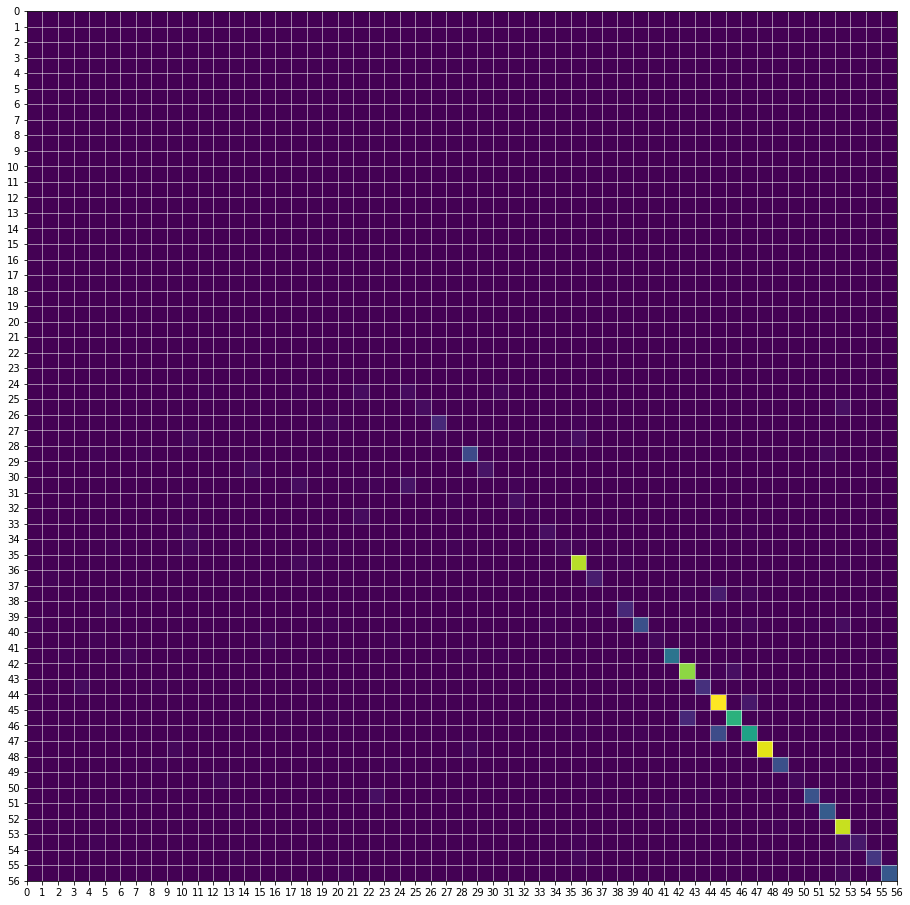

In [13]:
cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
fig = plt.figure(figsize=(16,16))
ax = plt.gca();
ax.set_xticks(np.arange(-.5, len(classes), 1))
ax.set_yticks(np.arange(-.5, len(classes), 1))
ax.set_xticklabels(np.arange(0, len(classes), 1))
ax.set_yticklabels(np.arange(0, len(classes), 1))
ax.imshow(cm)#, cmap="Pastel1")
ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)

# Tensorboard Results

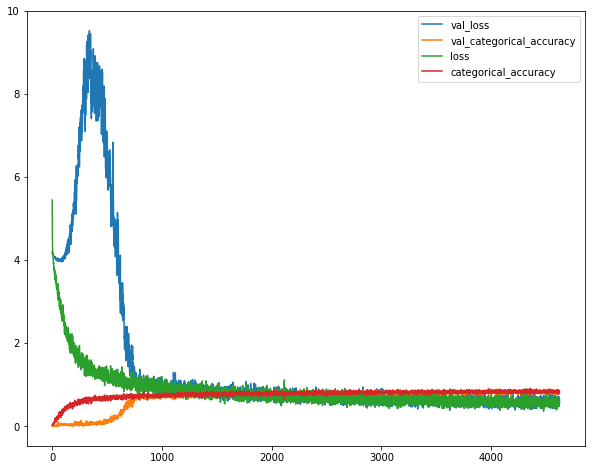

In [14]:
# saved "hist" results
df = pd.DataFrame(hist.history)
df.plot(figsize=(10,8))

In [15]:
# saved Tensorboard results
print("Opening saved results...")
df_loss = pd.read_csv('results/loss.csv')
df_val_loss = pd.read_csv('results/val_loss.csv')

plt.figure(figsize=(10,8))
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Loss'),
    mpatches.Patch(color='C1', label='Validation Loss')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)
plt.show()

df_loss = pd.read_csv('results/categorical_accuracy.csv')
df_val_loss = pd.read_csv('results/val_categorical_accuracy.csv')

plt.figure(figsize=(10,8))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Accuracy'),
    mpatches.Patch(color='C1', label='Validation Accuracy')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)
plt.show()

Opening saved results...


FileNotFoundError: File b'results/loss.csv' does not exist